In [1]:
!git clone https://github.com/z-mahmud22/Mask-RCNN_TF2.14.0.git

fatal: destination path 'Mask-RCNN_TF2.14.0' already exists and is not an empty directory.


In [2]:
#cd Mask-RCNN
#!cd Mask-RCNN_TF2.14.0.git
#!cd Mask-RCNN_TF2.14.0
%cd Mask-RCNN_TF2.14.0




/content/Mask-RCNN_TF2.14.0


In [3]:
import sys
print(sys.version)


3.10.12 (main, Nov  6 2024, 20:22:13) [GCC 11.4.0]


In [ ]:
# Install the Mask R-CNN-specific dependencies
#!pip install -r /tree/main/requirements.txt
!pip install -r requirements.txt


In [ ]:
!python3 setup.py install

In [6]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [7]:
import os
from pycocotools.coco import COCO

# Specify the path to your dataset (change the path accordingly)
data_dir = '/content/drive/MyDrive/Target2/target.v1i.coco/'


In [8]:
import os
import numpy as np
from pycocotools.coco import COCO
from mrcnn.utils import Dataset

class TargetDataset(Dataset):
    def load_target(self, dataset_dir, subset):
        """
        Load a subset of the Target dataset.
        dataset_dir: Root directory of the dataset.
        subset: The subset to load: 'train', 'valid', or 'test'.
        """
        self.add_class("target", 1, "target")

        # Define the path to the annotation file for the current subset
        annotations_path = os.path.join(dataset_dir, subset, '_annotations.coco.json')
        #annotations_path = os.path.join(dataset_dir, '_annotations.coco.json')#
        #annotations_path = os.path.join(dataset_dir, subset, 'annotations', '_annotations.coco.json')#


        # Load the COCO annotations for the current subset
        coco = COCO(annotations_path)

        # Add images to the dataset
        image_ids = coco.getImgIds()
        for image_id in image_ids:
            image_info = coco.loadImgs(image_id)[0]
            self.add_image(
                "target",
                image_id=image_id,
                path=os.path.join(dataset_dir, subset, image_info['file_name']),
                #path=os.path.join(dataset_dir, subset, 'images', image_info['file_name']),#
                #Ajouter un print#
                width=image_info['width'],
                height=image_info['height']
            )

    def load_mask(self, image_id):
        """
        Load instance masks for an image.
        """
        info = self.image_info[image_id]
        # Path to the correct annotation file for the subset (train/valid/test)
        annotations_path = os.path.join(os.path.dirname(info['path']), '_annotations.coco.json')
        coco = COCO(annotations_path)
        ann_ids = coco.getAnnIds(imgIds=info['id'])
        annotations = coco.loadAnns(ann_ids)

        masks = []
        class_ids = []
        for ann in annotations:
            mask = coco.annToMask(ann)
            masks.append(mask)
            class_ids.append(ann['category_id'])  # Ensure that class IDs are added

        # Ensure that masks and class_ids arrays are numpy arrays
        if len(masks) == 0:
            masks = np.zeros((info['height'], info['width'], 0))  # Handle empty masks
            class_ids = np.array([])  # No class IDs if no annotations

        # Stack masks and convert class_ids to numpy array
        return np.stack(masks, axis=-1), np.array(class_ids)

    def image_reference(self, image_id):
        return self.image_info[image_id]['path']


In [9]:
# Initialize and load the training dataset
dataset_train = TargetDataset()
dataset_train.load_target(data_dir, 'train')
dataset_train.prepare()


loading annotations into memory...
Done (t=3.63s)
creating index...
index created!


In [10]:
# Initialize and load the validation dataset
dataset_val = TargetDataset()
dataset_val.load_target(data_dir, 'valid')
dataset_val.prepare()


loading annotations into memory...
Done (t=0.86s)
creating index...
index created!


In [11]:
# Initialize and load the testing dataset
dataset_test = TargetDataset()
dataset_test.load_target(data_dir, 'test')
dataset_test.prepare()


loading annotations into memory...
Done (t=0.91s)
creating index...
index created!


In [ ]:
!wget https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5


In [13]:
# Import necessary libraries
from mrcnn.model import MaskRCNN
from mrcnn.config import Config

# Define your custom configuration class
class CustomConfig(Config):
    NAME = "target"  # Name of the dataset or task
    IMAGES_PER_GPU = 2  # Adjust this based on the memory of your GPU
    NUM_CLASSES = 2  # Including background (1) + target (1)
    STEPS_PER_EPOCH = 250
    VALIDATION_STEPS = 100  # Set validation steps based on the dataset size
    LEARNING_RATE = 0.001  # Learning rate for training
    IMAGE_MIN_DIM = 512  # Minimum image dimension for resizing
    IMAGE_MAX_DIM = 512  # Maximum image dimension for resizing
    GPU_COUNT = 1  # Number of GPUs (adjust if you have more)


# Instantiate your custom configuration
config = CustomConfig()


In [14]:
# Step 1: Create the model in training mode
model = MaskRCNN(mode="training", config=config, model_dir='/content')

# Step 2: Load pre-trained weights (COCO weights) but exclude the conflicting layers
model.load_weights('mask_rcnn_coco.h5', by_name=True, exclude=["mrcnn_bbox_fc", "mrcnn_class_logits", "mrcnn_mask"])

In [15]:
# Step 3: Train the model (fine-tuning only the heads)
model.train(dataset_train, dataset_val, learning_rate=config.LEARNING_RATE, epochs=10, layers='heads')



Starting at epoch 0. LR=0.001

Checkpoint Path: /content/target20241215T1319/mask_rcnn_target_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
rpn_model              (Functional)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDistributed)
mrcnn_bbox_fc          (TimeDistributed)
mrcnn_mask_deconv      (TimeDistributed

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Streaming output truncated to the last 5000 lines.
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
100/250 [===========>..................] - ETA: 11:23 - batch: 49.5000 - size: 2.0000 - loss: 2.1209 - rpn_class_loss: 0.0538 - rpn_bbox_loss: 0.7080 - mrcnn_class_loss: 0.0794 - mrcnn_bbox_loss: 0.8244 - mrcnn_mask_loss: 0.4552loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creatin

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
188/250 [=====================>........] - ETA: 1:24 - batch: 93.5000 - size: 2.0000 - loss: 0.2189 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0551 - mrcnn_class_loss: 0.0146 - mrcnn_bbox_loss: 0.0470 - mrcnn_mask_loss: 0.0964loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index..

In [16]:
# Bloc de vérification de l’historique
print(model.keras_model.history.history)  # Vérifie si les données d'historique existent


{'loss': [1.6886649572849273, 1.0262771768569947, 0.7076269313097, 0.5294161685705185, 0.4253150639533997, 0.3237164772748947, 0.321503774613142, 0.24938774079084397, 0.28125714933872226, 0.22000366461277007], 'rpn_class_loss': [0.041597336530685425, 0.022789601236581802, 0.01523698028177023, 0.011385392397642136, 0.009783424437046051, 0.007854181341826916, 0.007485819980502129, 0.007016765885055065, 0.006265665404498577, 0.005611309316009283], 'rpn_bbox_loss': [0.5712661743164062, 0.3349195420742035, 0.19319558143615723, 0.13388592004776, 0.11353210359811783, 0.07741668075323105, 0.0807277038693428, 0.058658938854932785, 0.08171722292900085, 0.05663372203707695], 'mrcnn_class_loss': [0.07149351388216019, 0.047015950083732605, 0.04053477570414543, 0.032794736325740814, 0.02859196811914444, 0.02310194820165634, 0.020280854776501656, 0.015215984545648098, 0.015550157055258751, 0.014161601662635803], 'mrcnn_bbox_loss': [0.6115059852600098, 0.33064553141593933, 0.2265428900718689, 0.157312

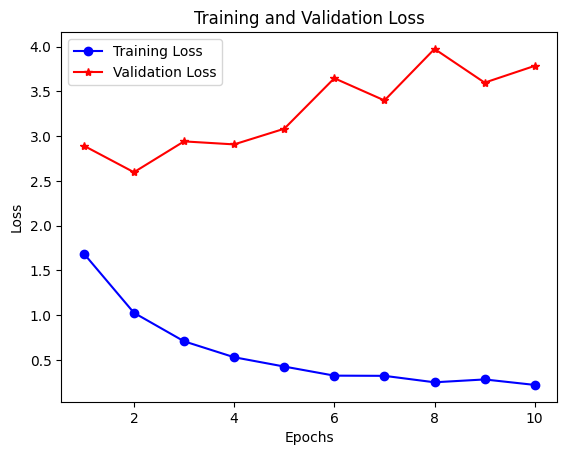

In [17]:
history_path = os.path.join('/content', 'training_logs.txt')
with open(history_path, 'w') as log_file:
    log_file.write(str(model.keras_model.history.history))  # Save training history

# Step 5: Generate a Plot of Losses (Manual Implementation)
import matplotlib.pyplot as plt

loss = model.keras_model.history.history['loss']
val_loss = model.keras_model.history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'r*-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Instructions for updating:
Use fn_output_signature instead


Re-starting from epoch 10
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
load

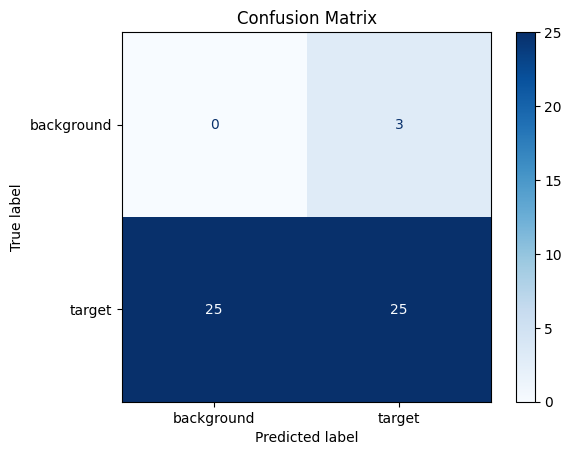


*** No instances to display *** 



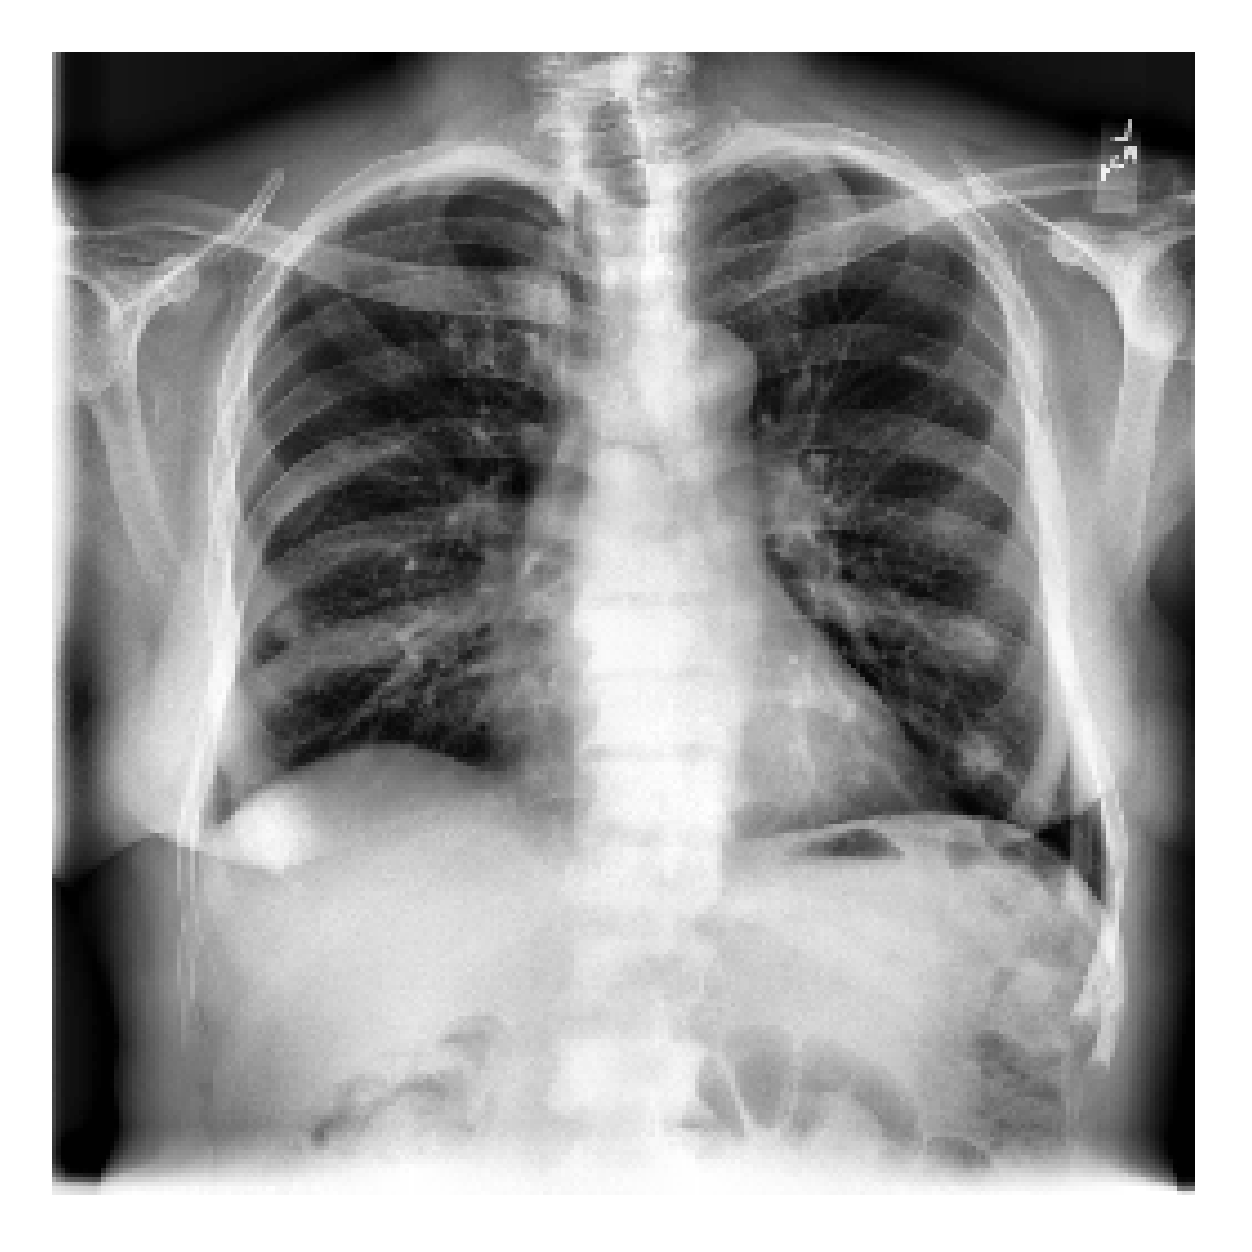


*** No instances to display *** 



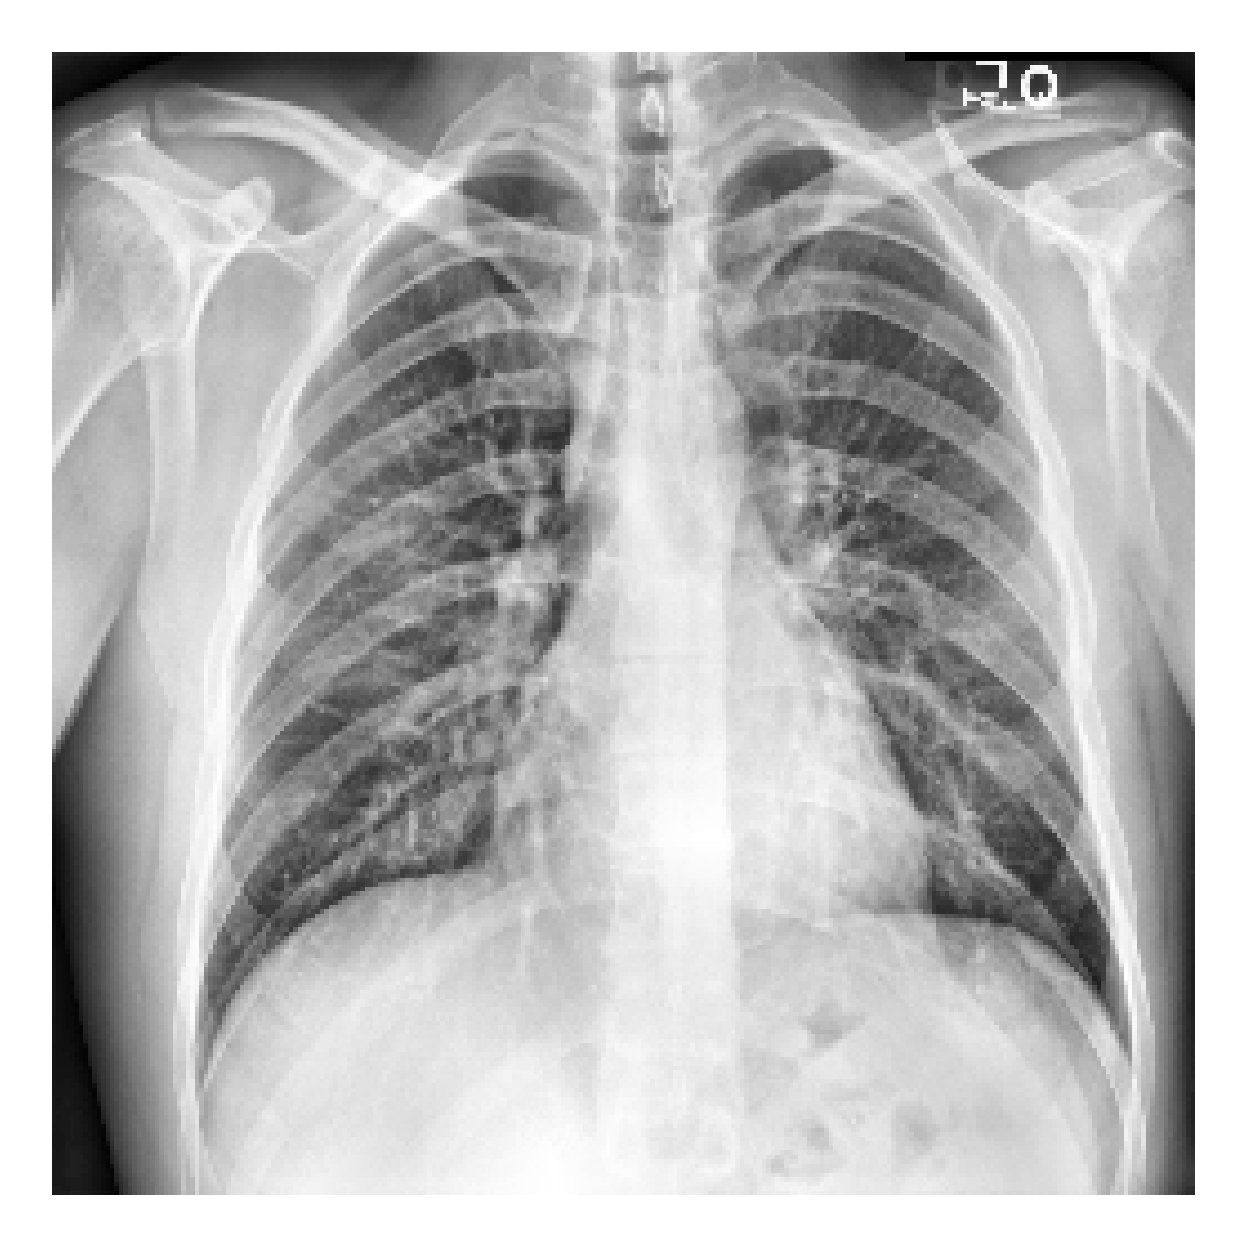


*** No instances to display *** 



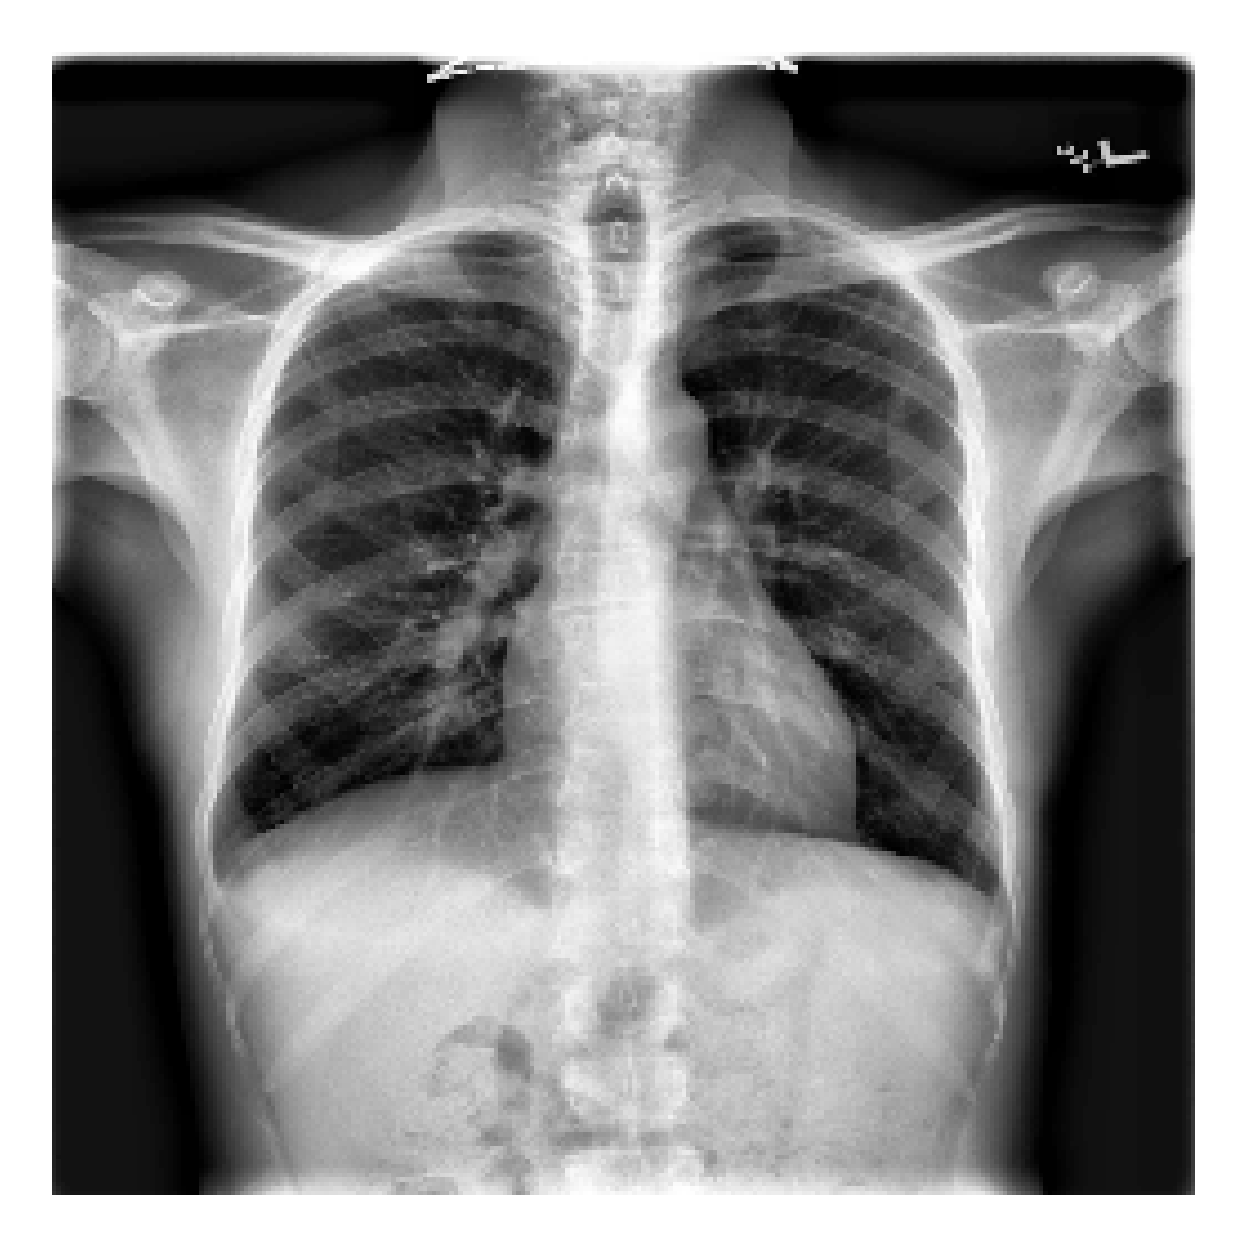

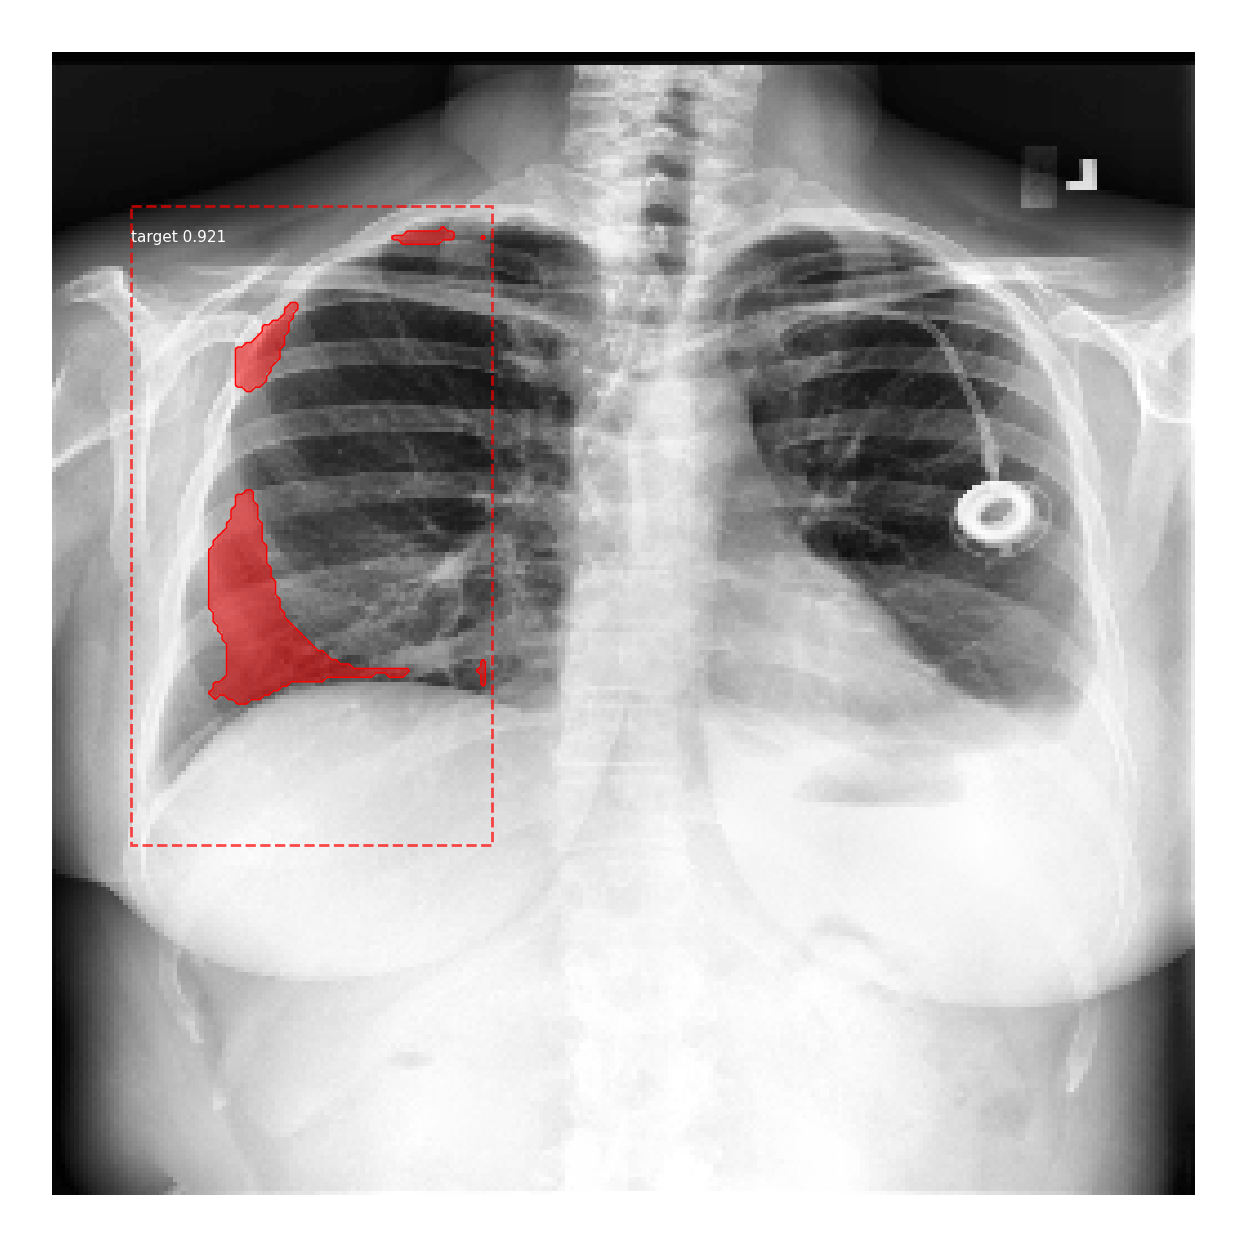

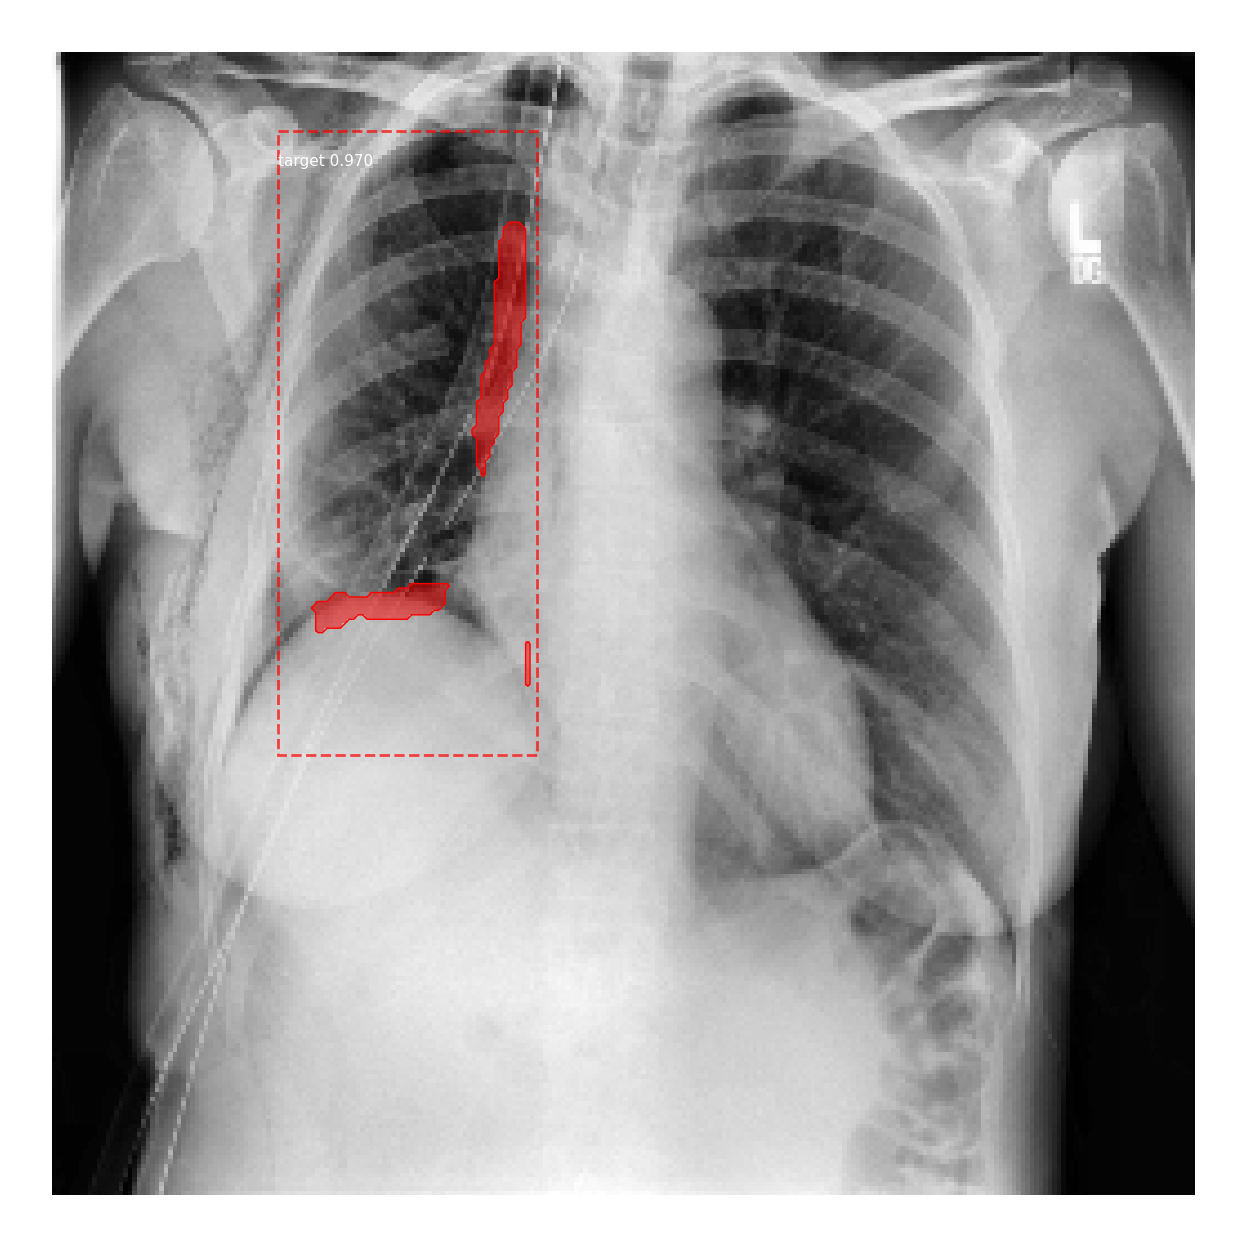

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from mrcnn.model import MaskRCNN
from mrcnn.config import Config
import matplotlib.pyplot as plt

# Step 4.1: Create a model for inference
class InferenceConfig(Config):
    NAME = "target"  # Change from "rabbit" to "target"
    NUM_CLASSES = 1 + 1  # Background + target
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()
# Ajustez ici le seuil de confiance
inference_config.DETECTION_MIN_CONFIDENCE = 0.9  # Par exemple, à 50%           CODE AJOUTE
inference_model = MaskRCNN(mode="inference", config=inference_config, model_dir='/content')

# Load the trained weights into the inference model
inference_model.load_weights(model.find_last(), by_name=True)

# Step 4.2: Collect true and predicted labels
true_labels = []
pred_labels = []

for image_id in dataset_test.image_ids:
    # Load true labels (class IDs) from the dataset
    true_masks, true_classes = dataset_test.load_mask(image_id)

    # Predict the image using the inference model
    image = dataset_test.load_image(image_id)
    pred = inference_model.detect([image], verbose=0)[0]

    # Align true and predicted classes
    if len(true_classes) == len(pred['class_ids']):
        true_labels.extend(true_classes)
        pred_labels.extend(pred['class_ids'])
    else:
        # Handle mismatched cases
        true_labels.extend(true_classes)
        pred_labels.extend(pred['class_ids'])

        # Fill with '0' (background class) for unmatched entries
        if len(true_classes) > len(pred['class_ids']):
            pred_labels.extend([0] * (len(true_classes) - len(pred['class_ids'])))
        elif len(pred['class_ids']) > len(true_classes):
            true_labels.extend([0] * (len(pred['class_ids']) - len(true_classes)))

# Step 4.3: Generate and plot the confusion matrix
cm = confusion_matrix(true_labels, pred_labels, labels=[0, 1])  # Add '0' for background
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['background', 'target'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Step 5: Visualize test predictions (Successes and Mistakes)
from mrcnn.visualize import display_instances
import random

# Select 5 random image IDs from the test dataset
for i in random.sample(list(dataset_test.image_ids), 5):
    image = dataset_test.load_image(i)  # Load the image
    results = inference_model.detect([image], verbose=0)  # Perform detection

    # Visualize the prediction
    display_instances(
        image,
        results[0]['rois'],
        results[0]['masks'],
        results[0]['class_ids'],
        dataset_test.class_names,
        results[0]['scores']
    )


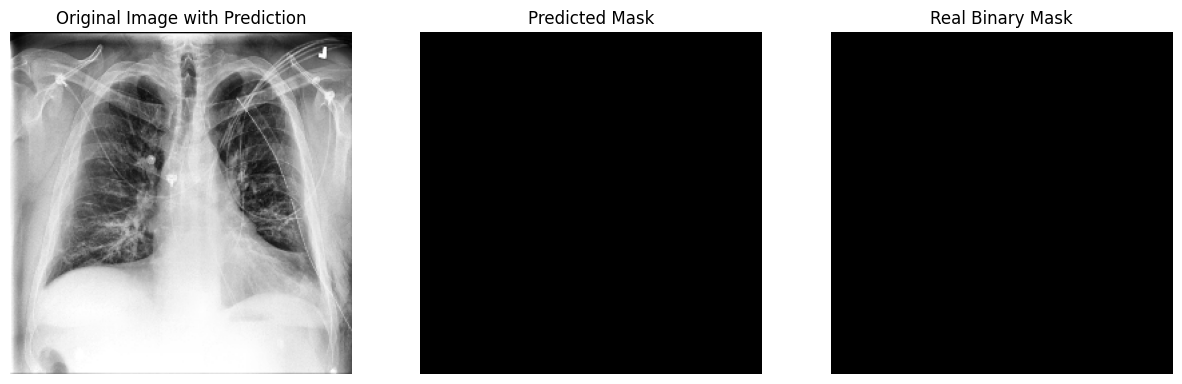

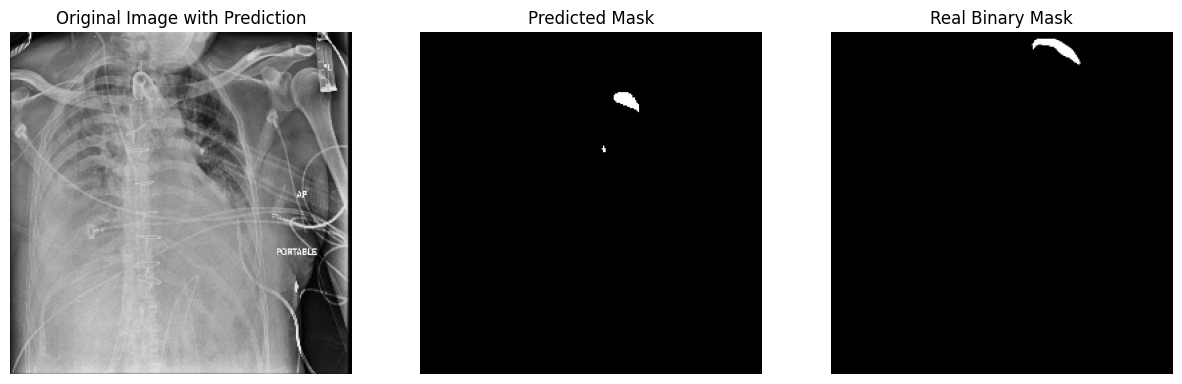

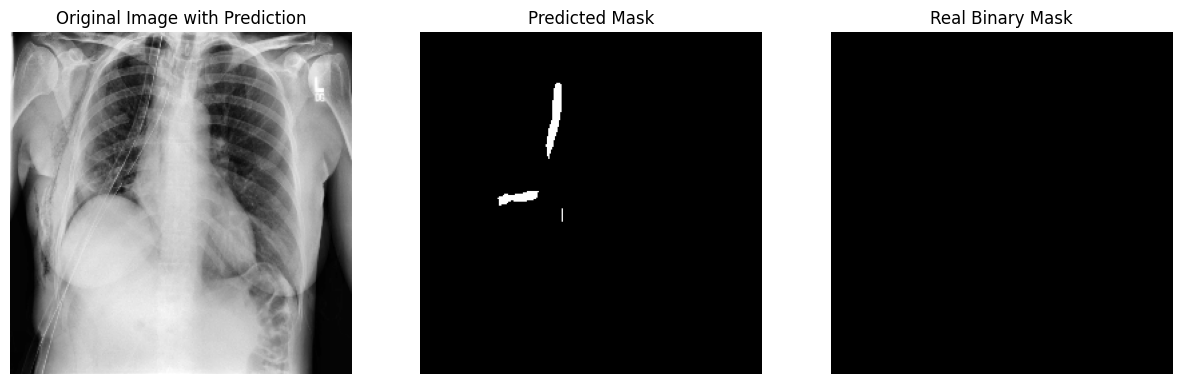

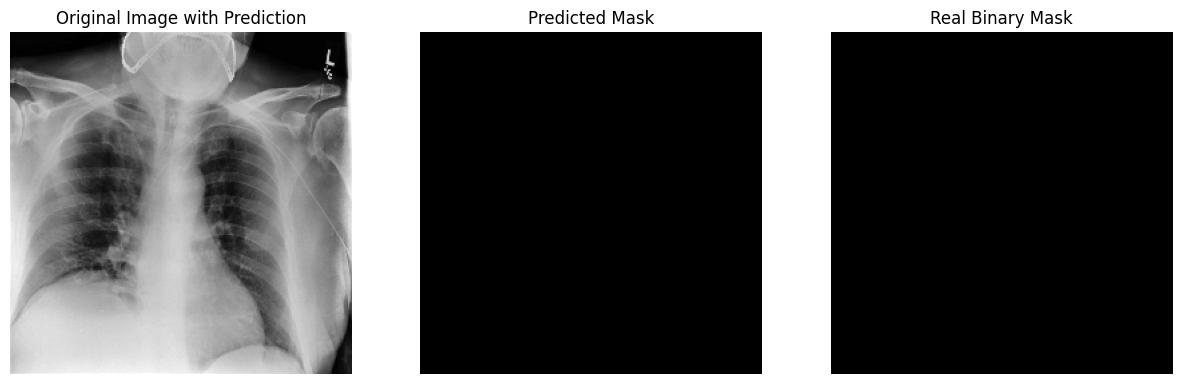

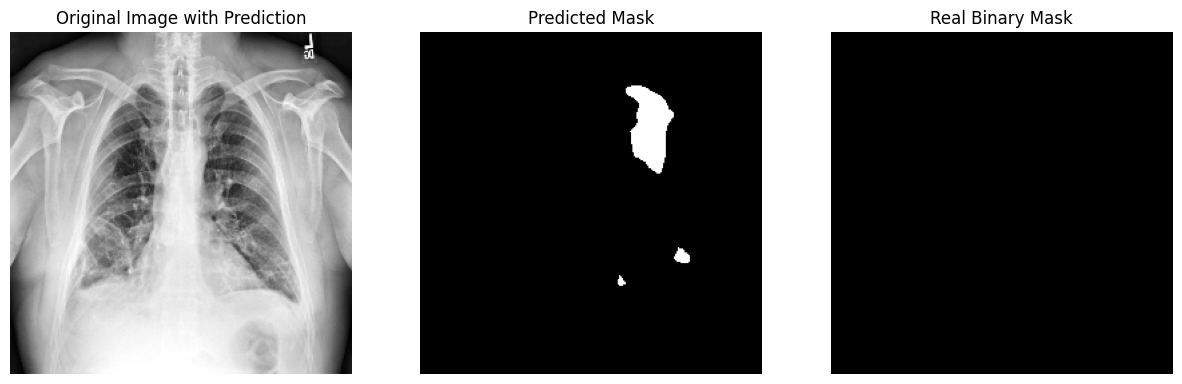

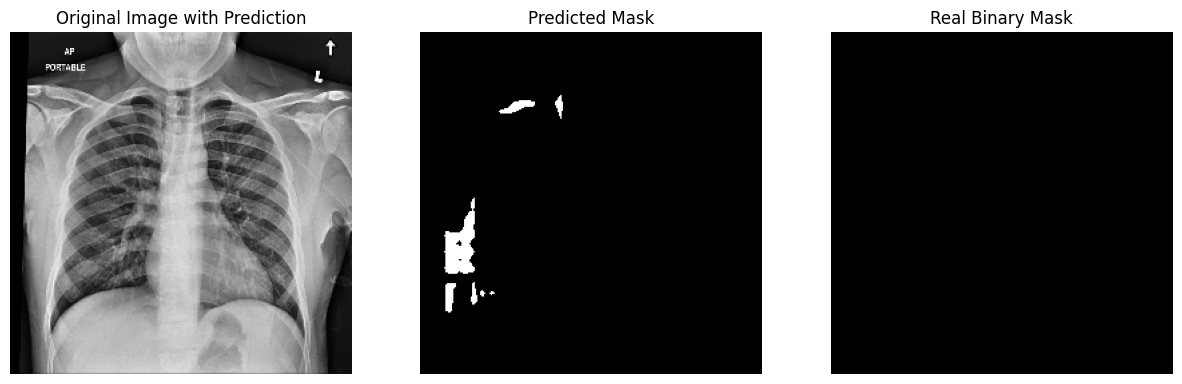

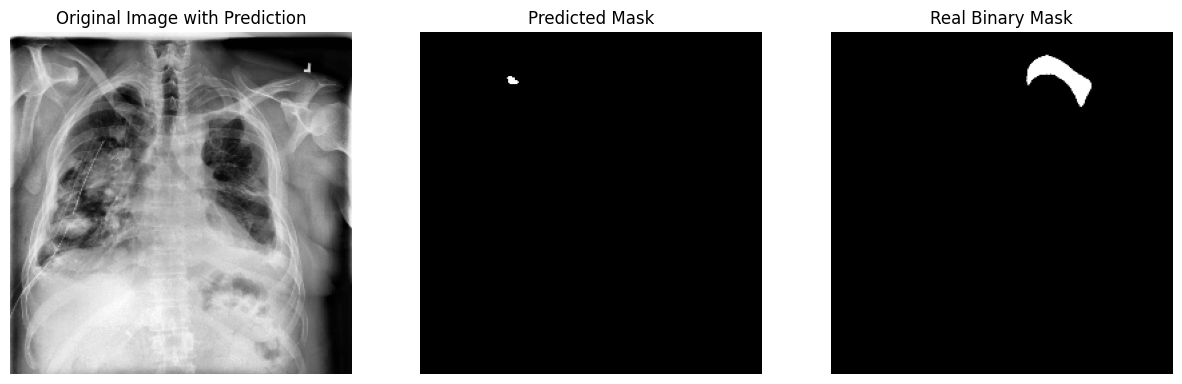

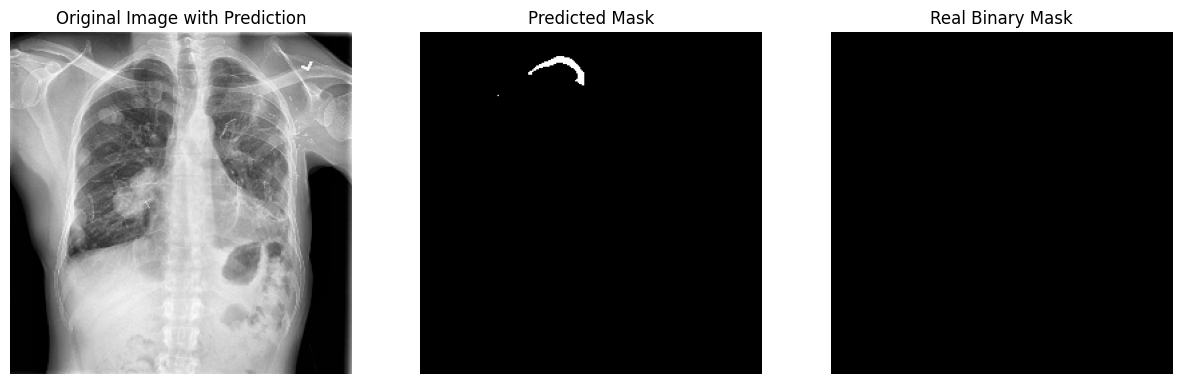

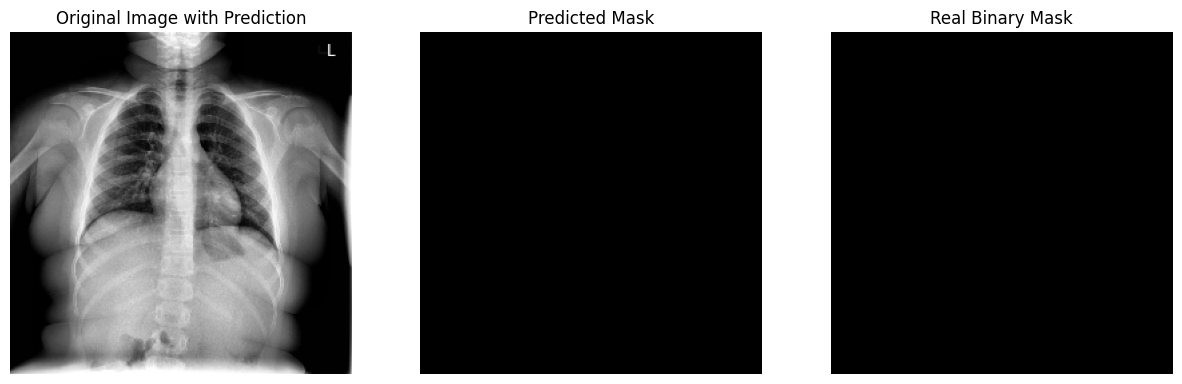

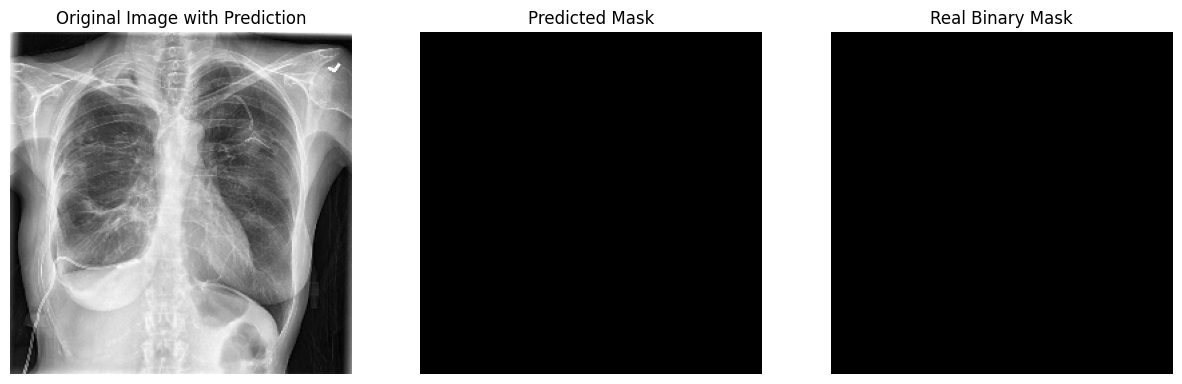

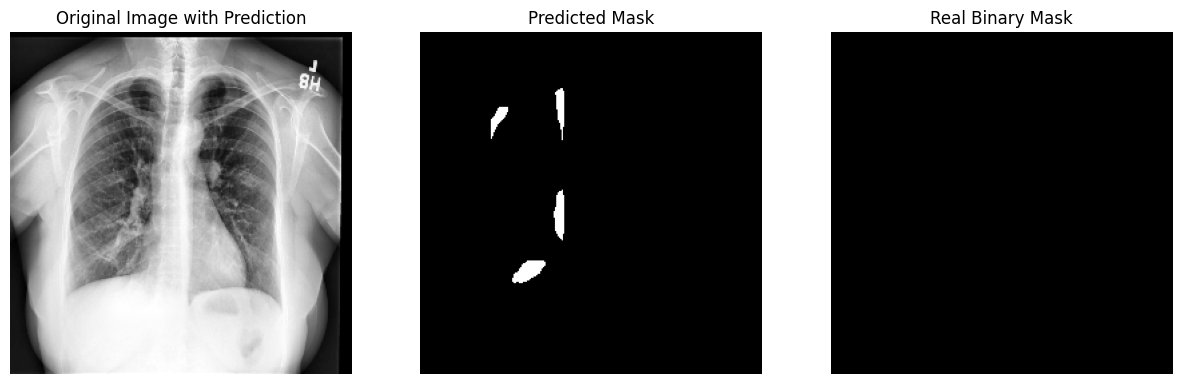

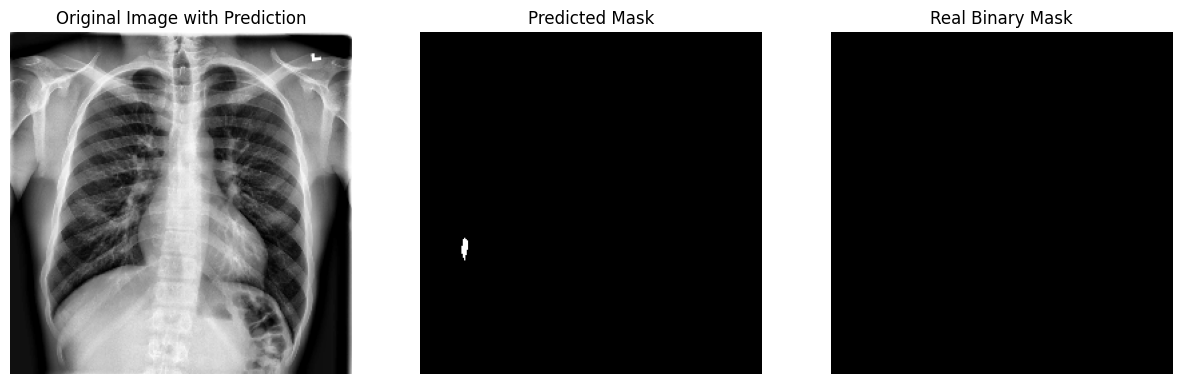

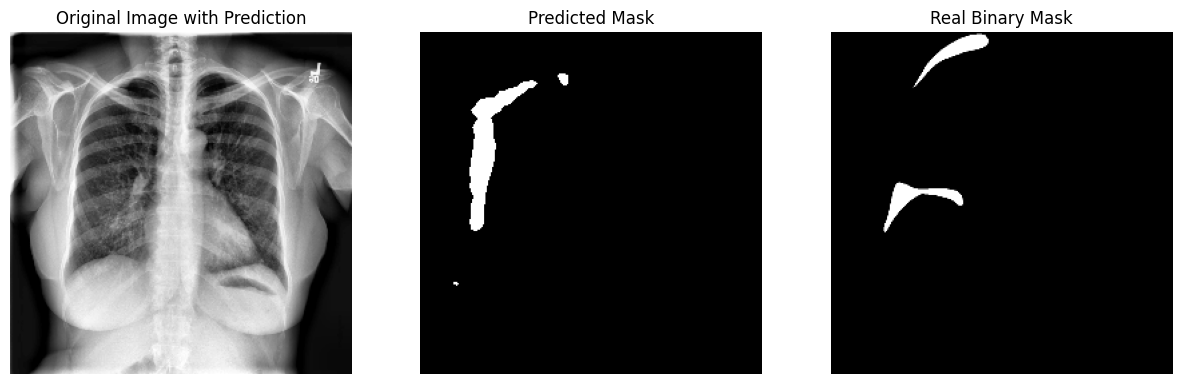

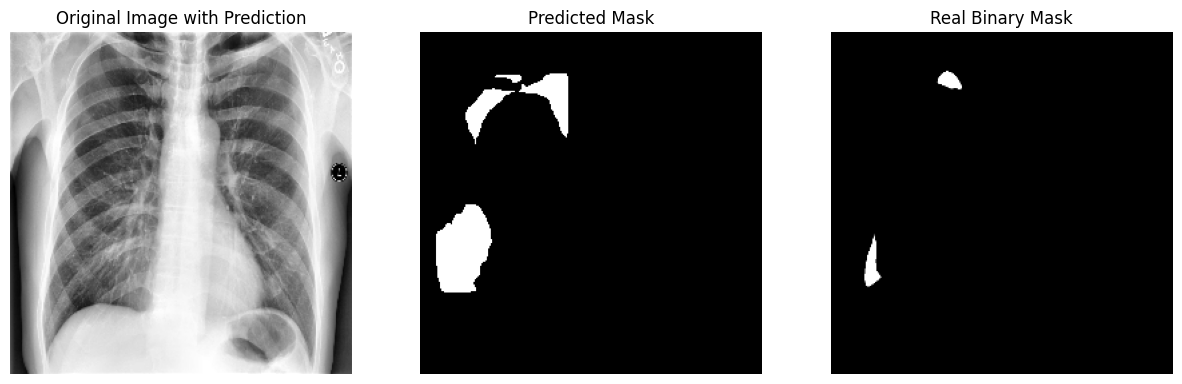

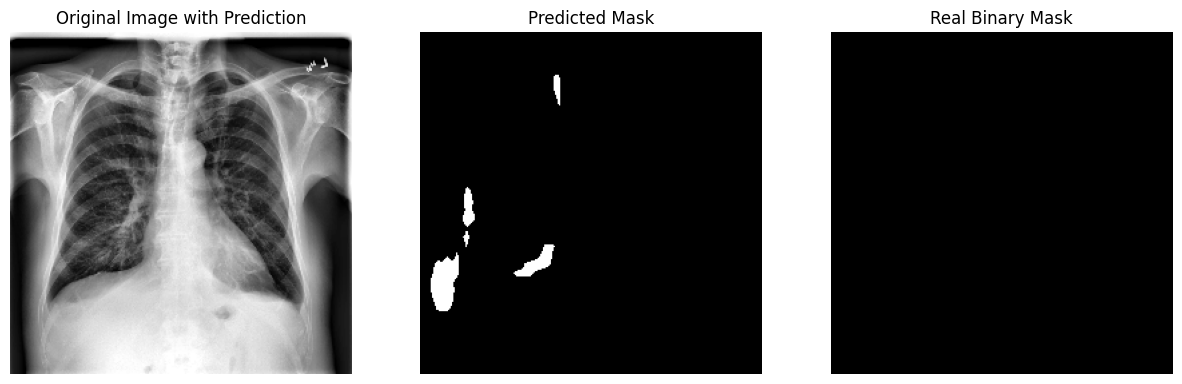

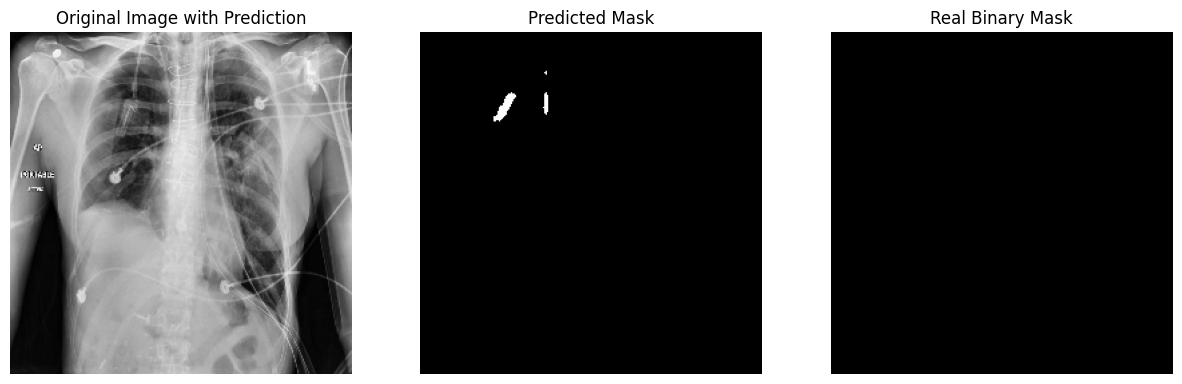

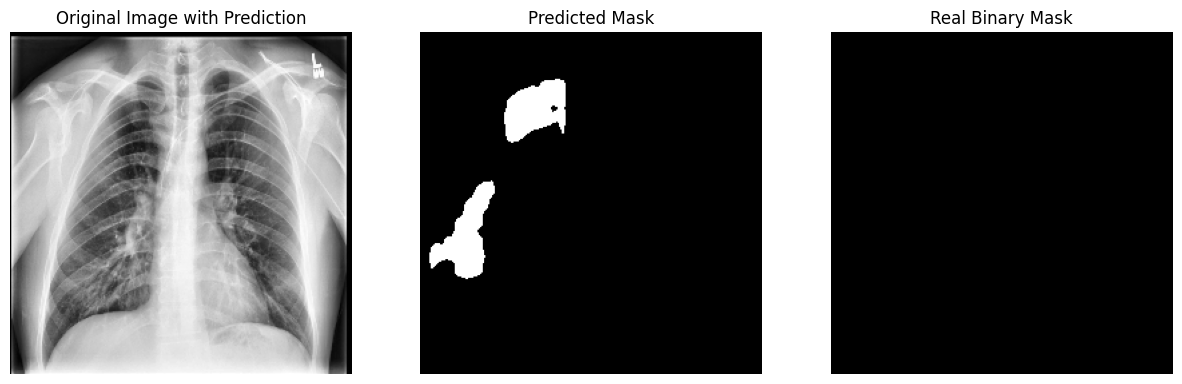

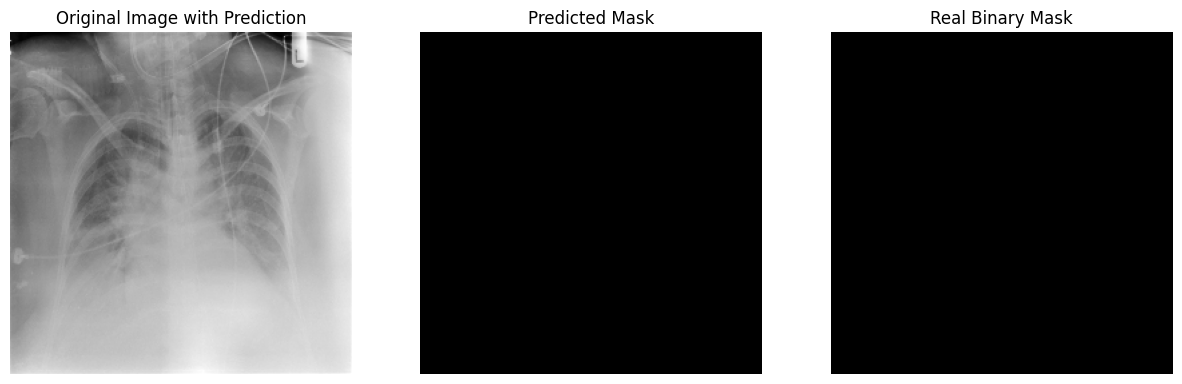

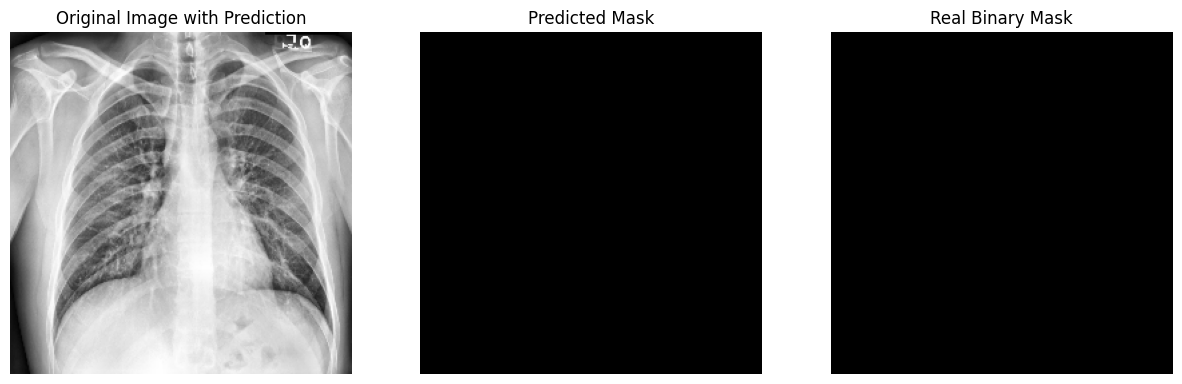

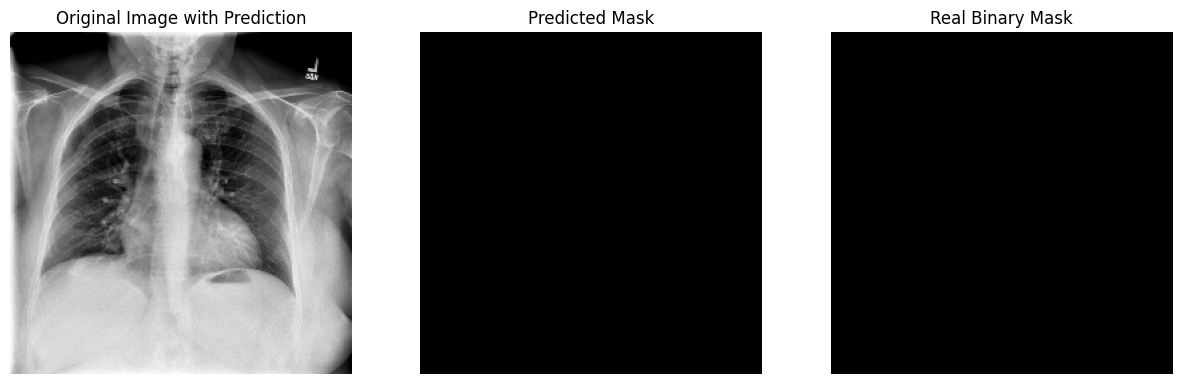

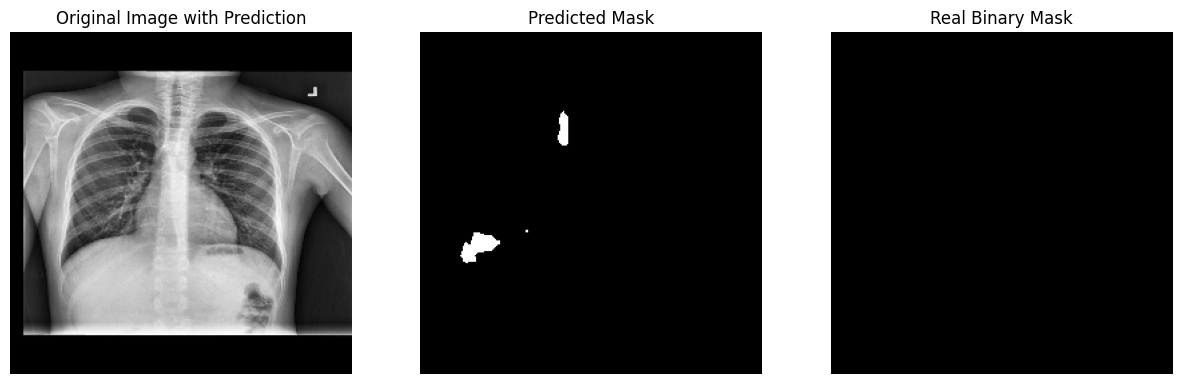

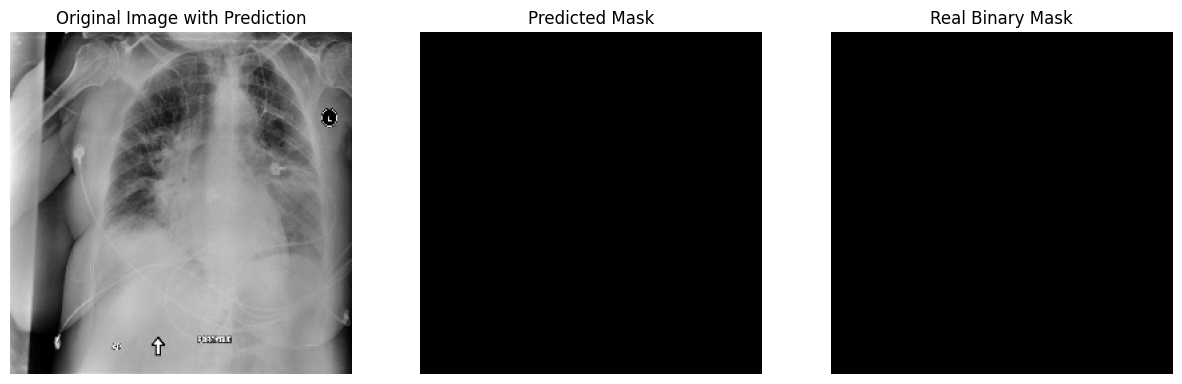

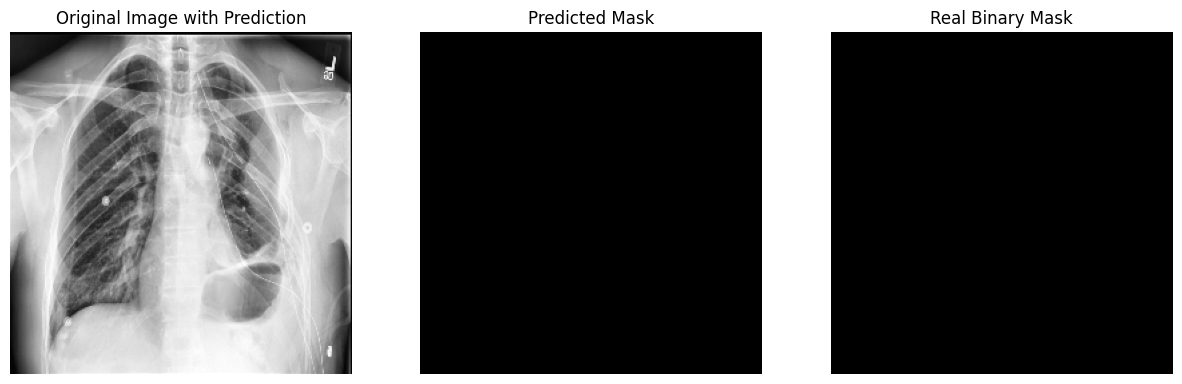

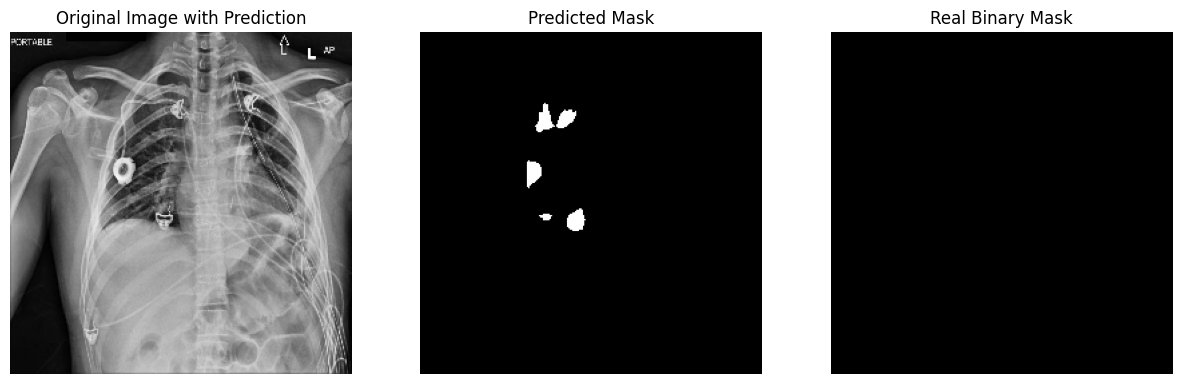

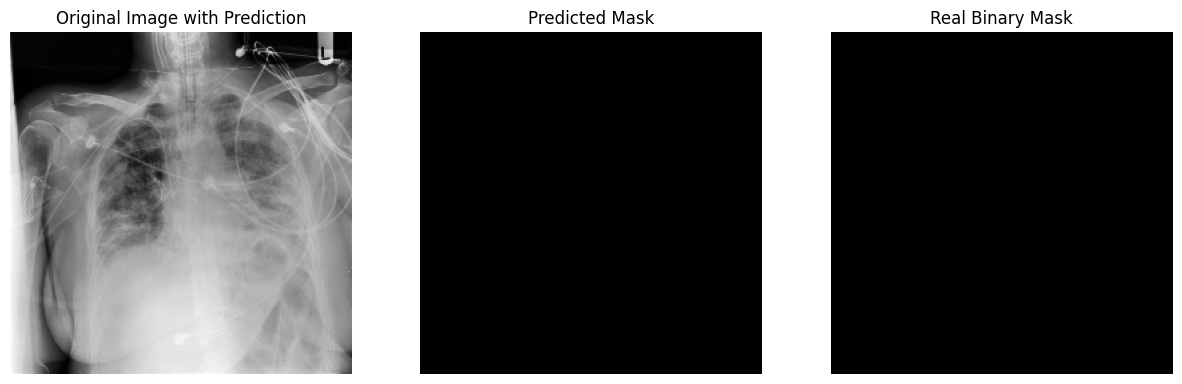

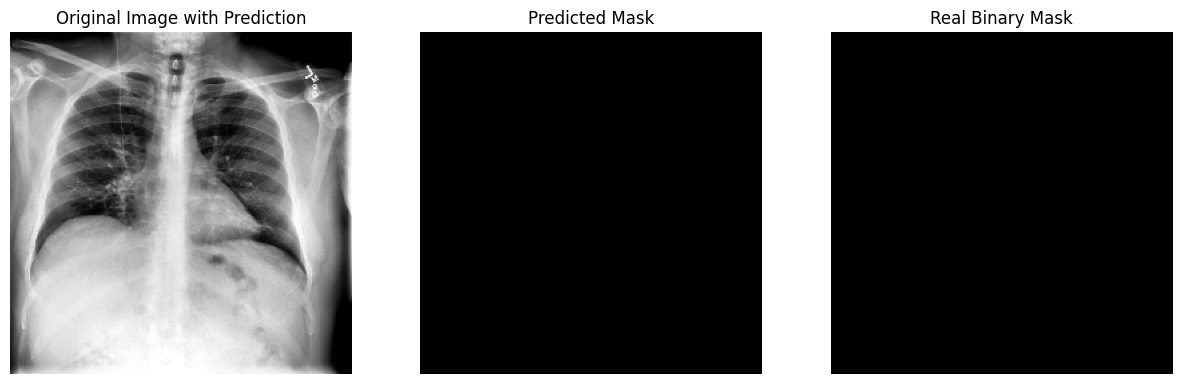

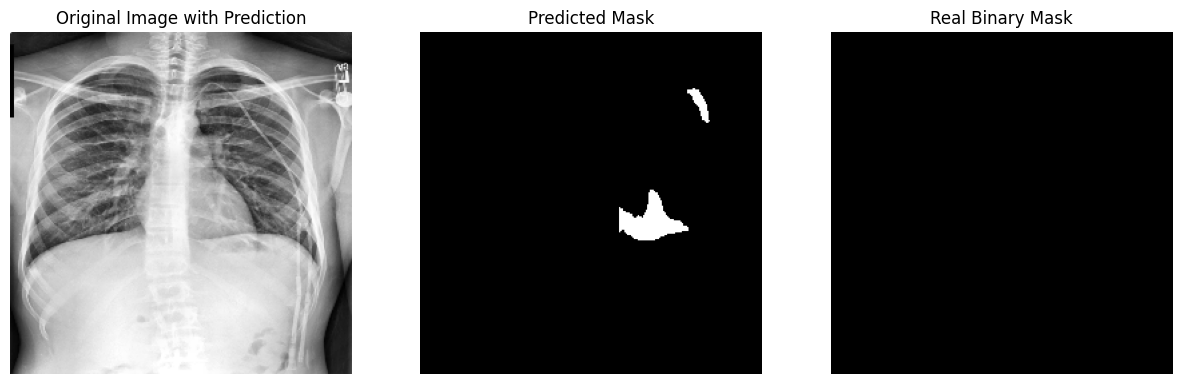

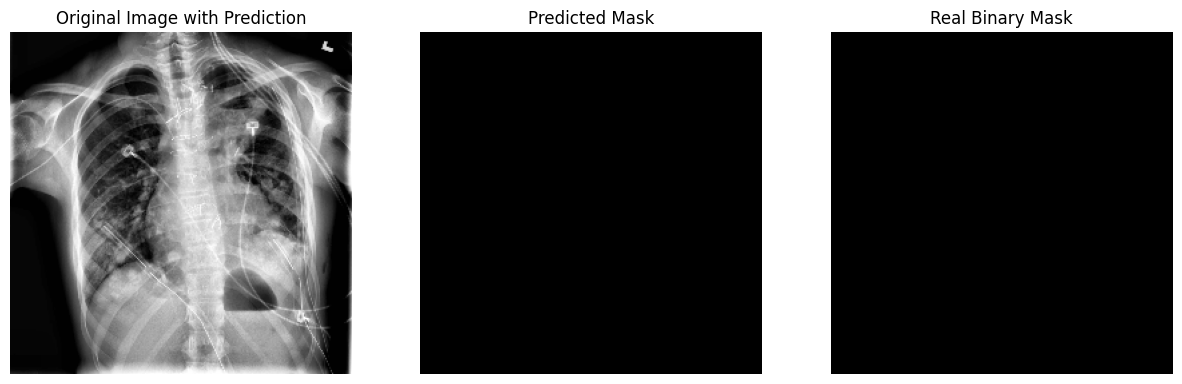

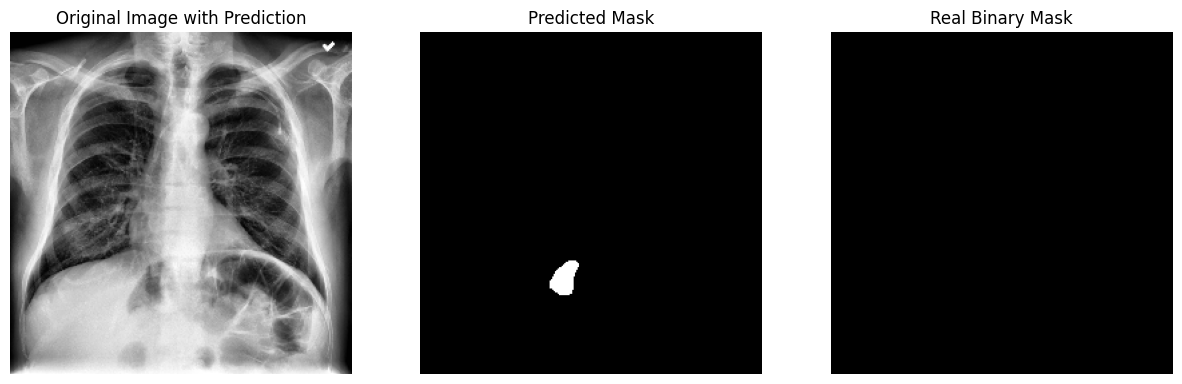

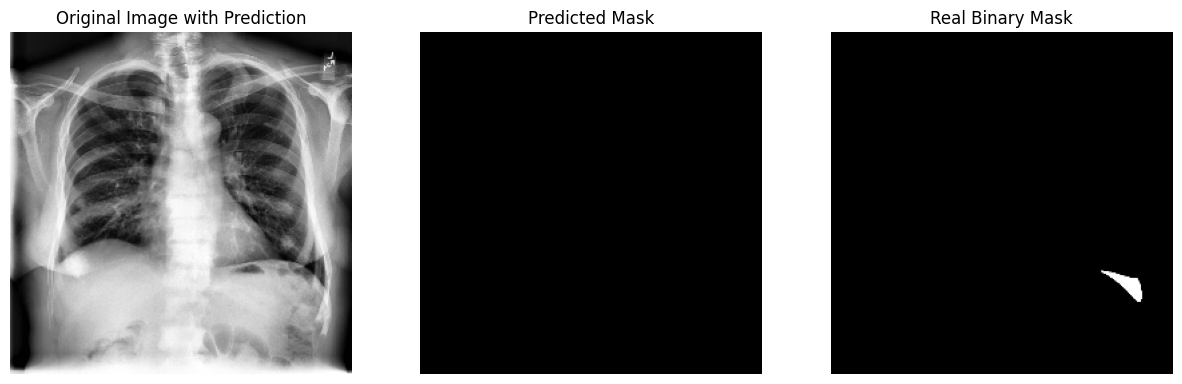

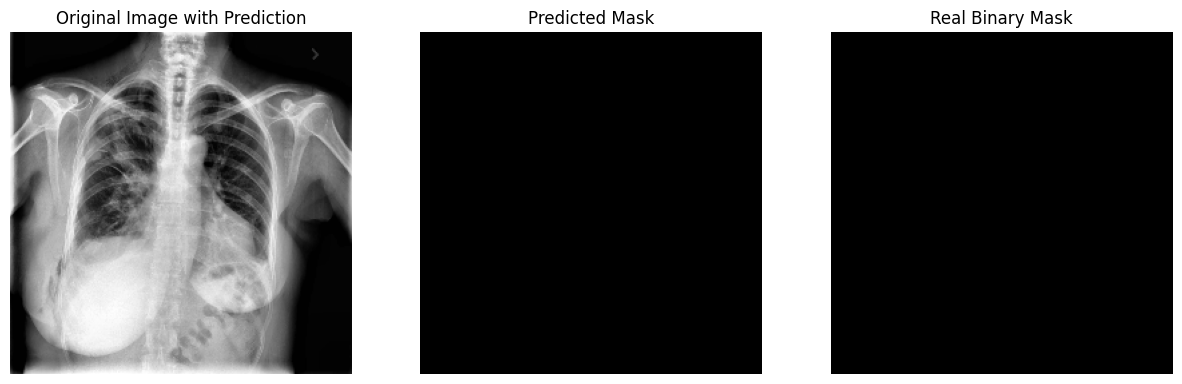

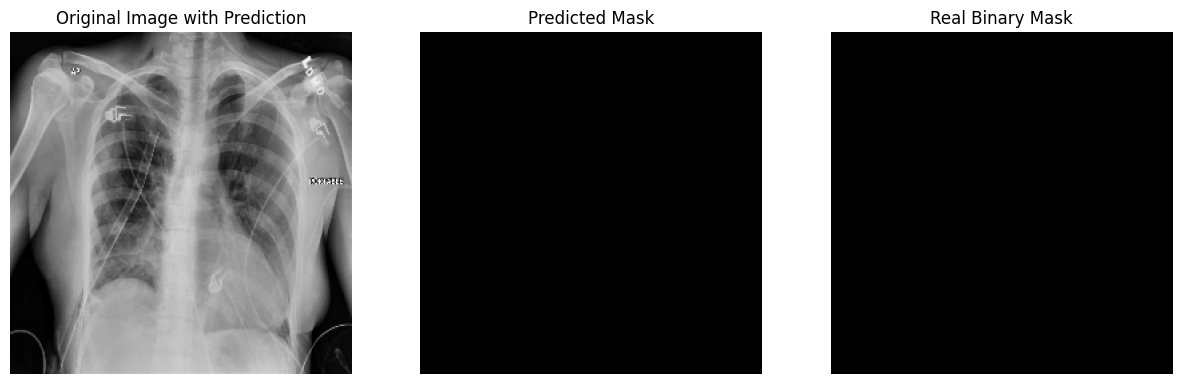

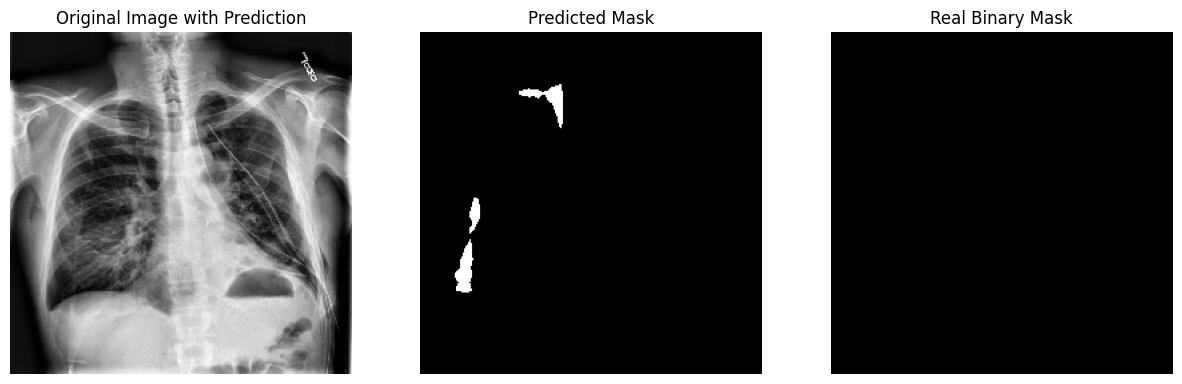

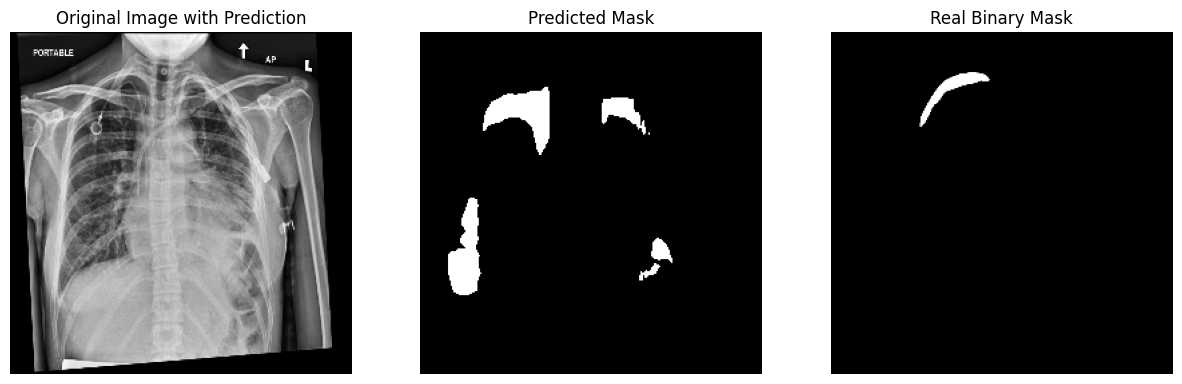

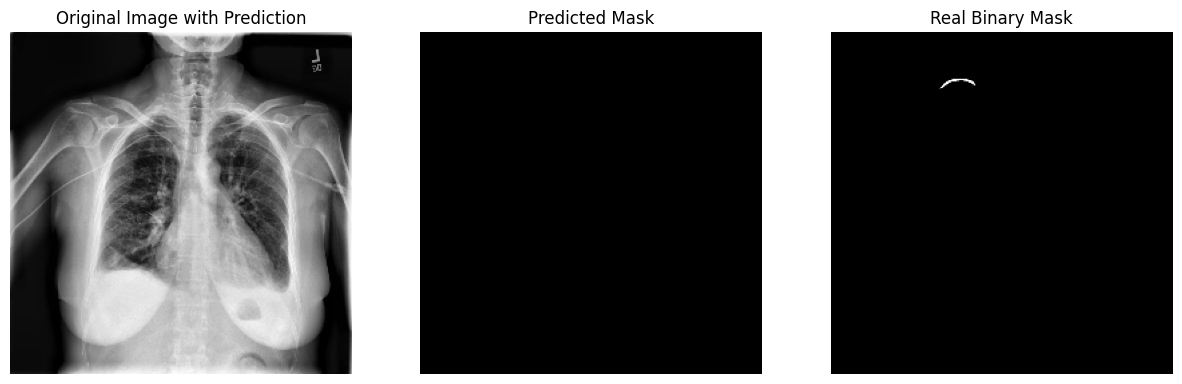

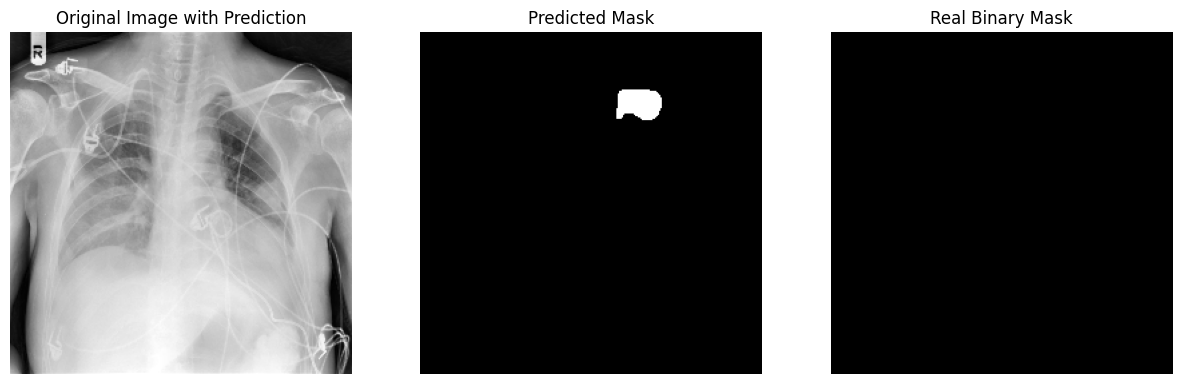

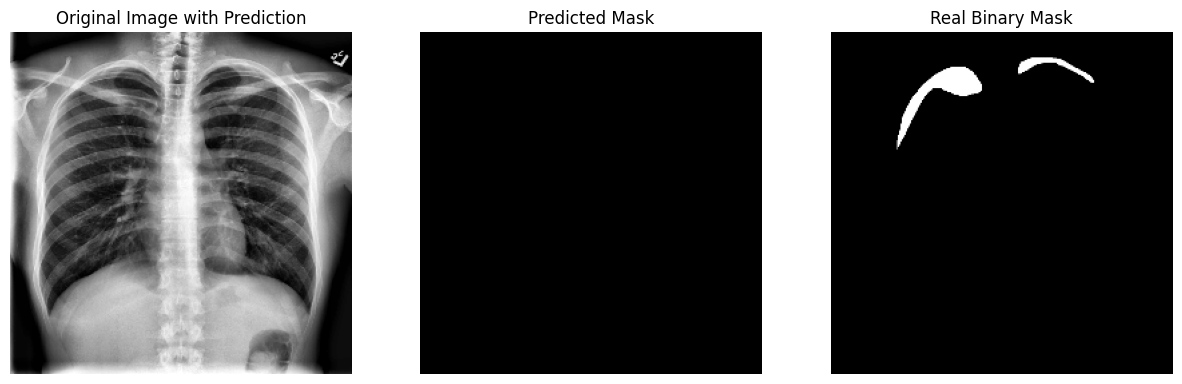

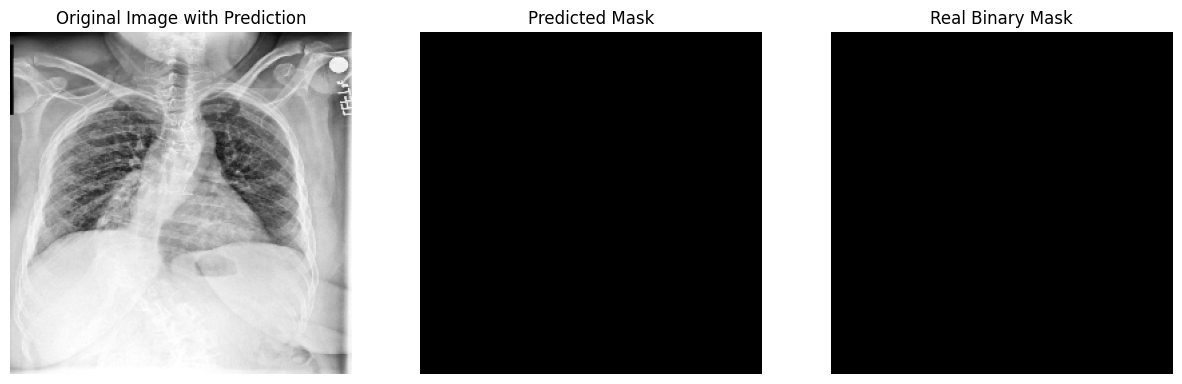

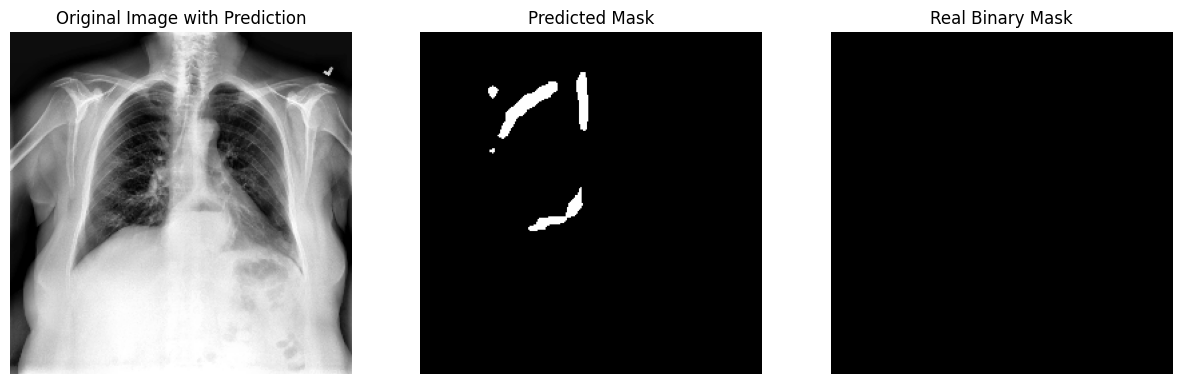

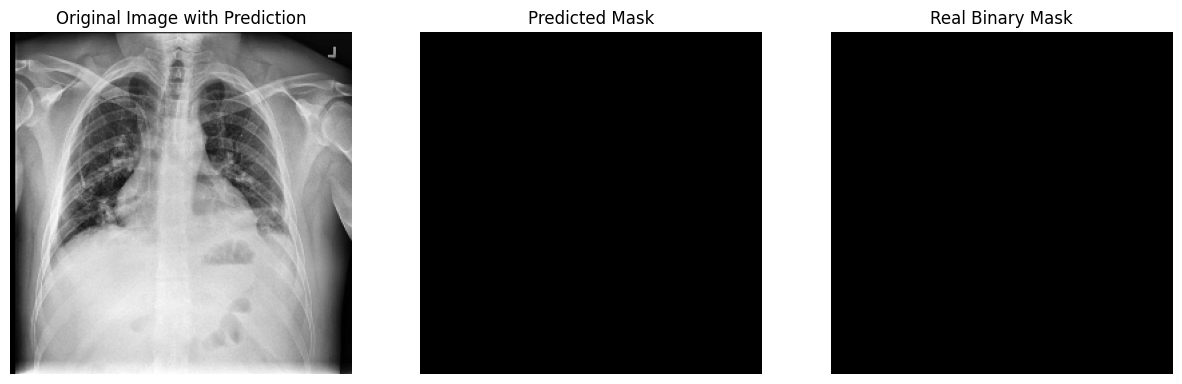

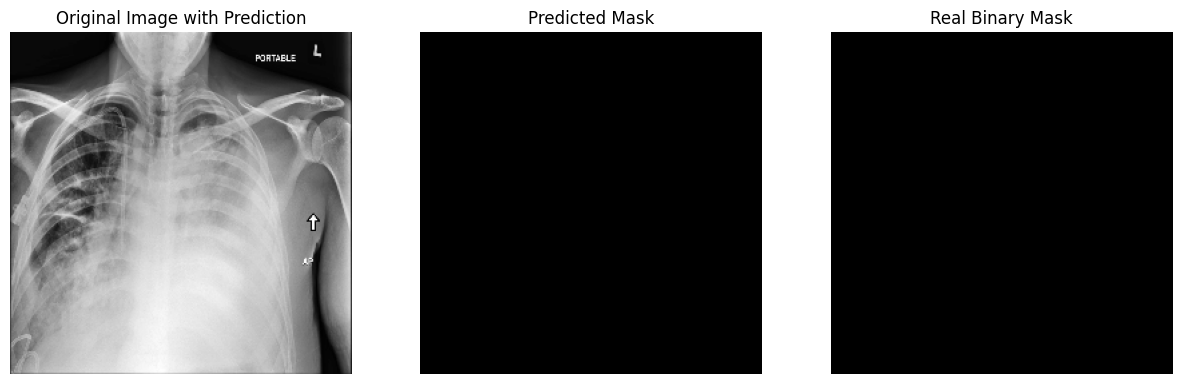

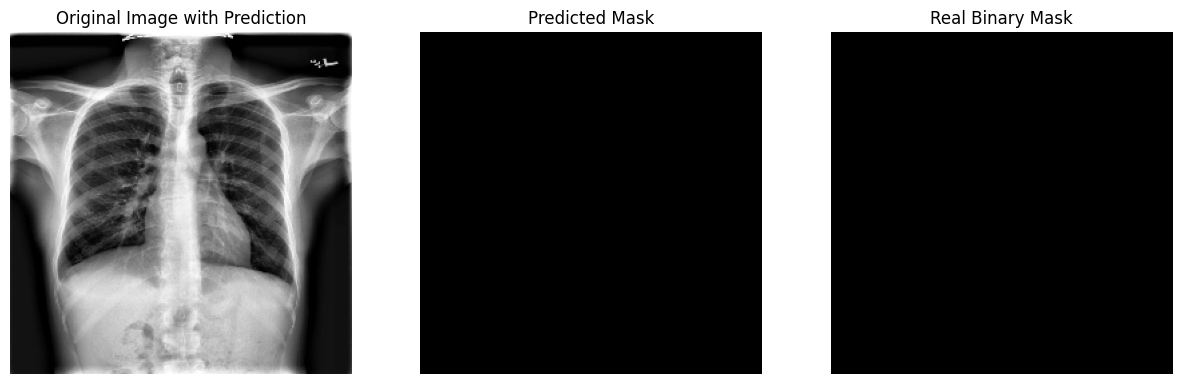

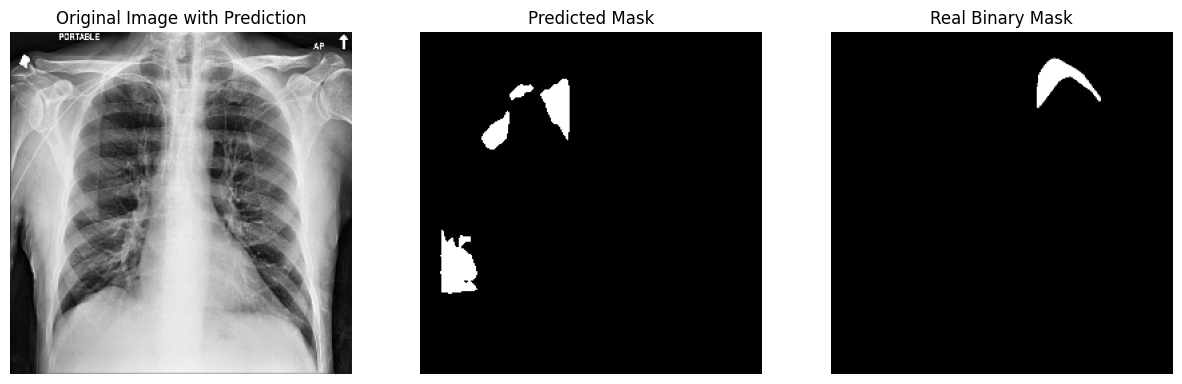

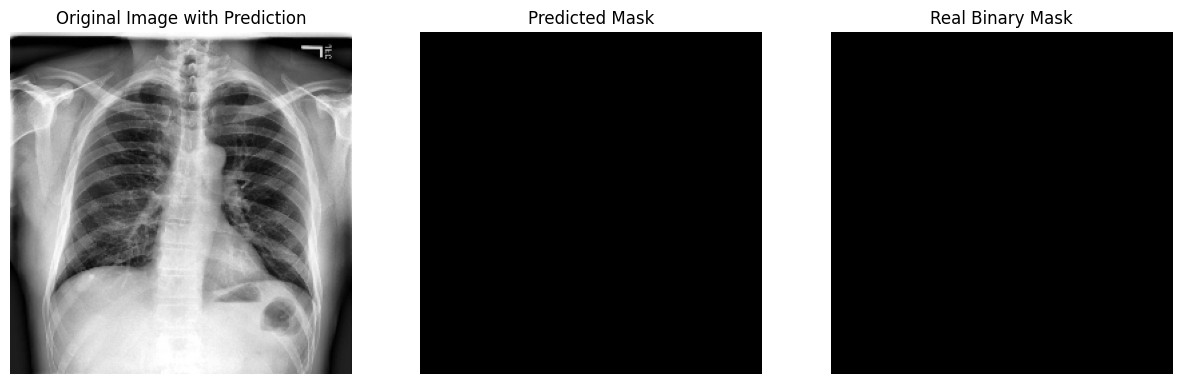

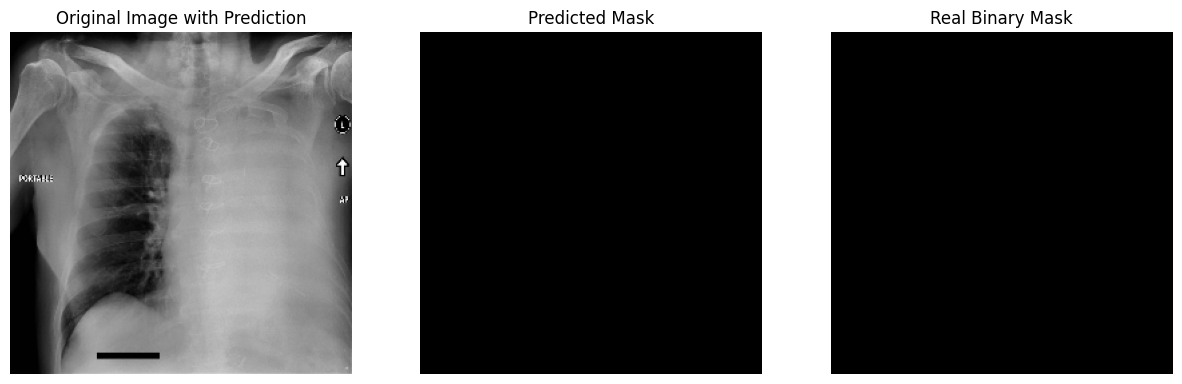

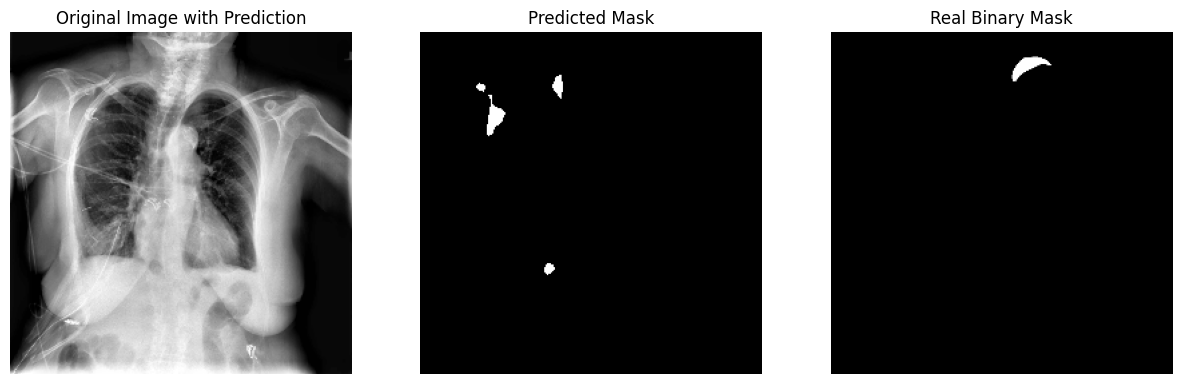

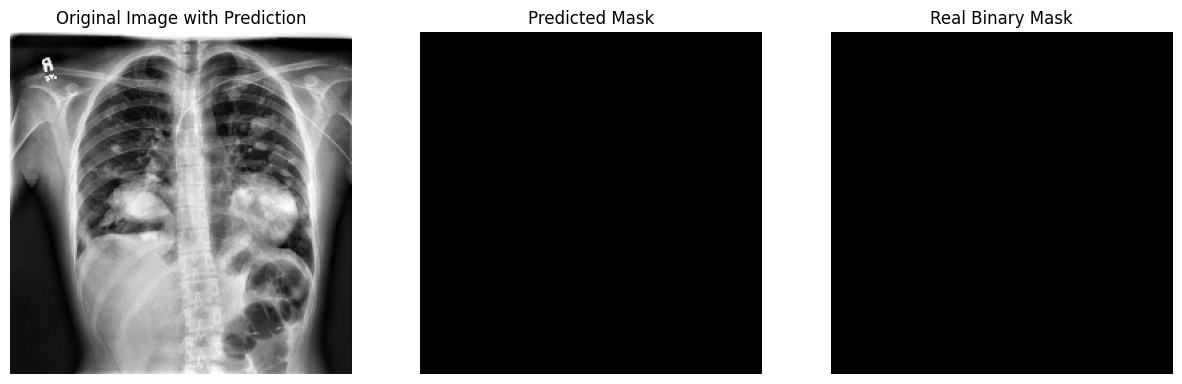

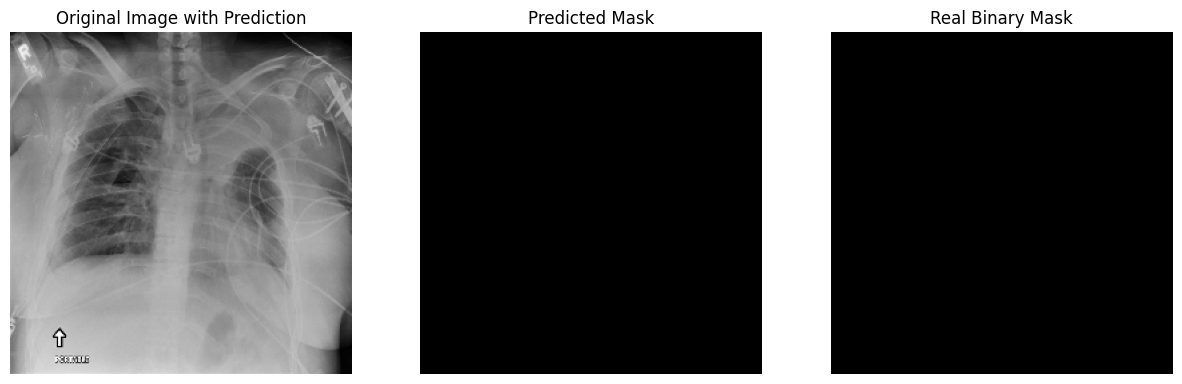

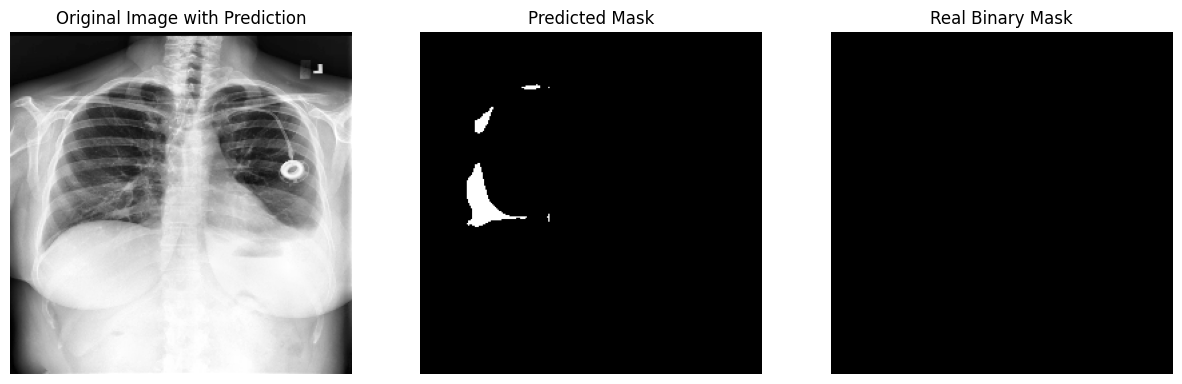

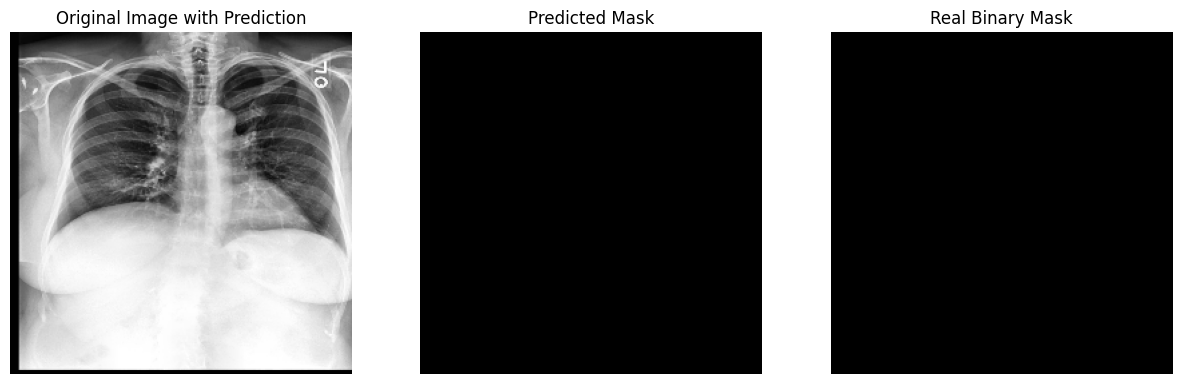

In [19]:
# 3 images_codes à conserver
from mrcnn.visualize import display_instances
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os

# Définir le chemin vers le dossier contenant les masques binaires
mask_binary = '/content/drive/MyDrive/Target2/target.v1i.coco/test_Masks/'

# Récupérer les fichiers des masques binaires (assuré qu'ils sont triés)
mask_files = sorted(os.listdir(mask_binary))

# Parcourir les images de test et leurs masques associés
for idx, image_id in enumerate(dataset_test.image_ids):
    image = dataset_test.load_image(image_id)  # Charger l'image
    results = inference_model.detect([image], verbose=0)  # Effectuer la prédiction

    # Charger le masque réel à partir du dossier (utiliser l'ordre)
    mask_path = os.path.join(mask_binary, mask_files[idx])
    binary_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Charger en niveaux de gris

    # Initialiser un masque vide (de la même taille que l'image)
    pred_mask = np.zeros((image.shape[0], image.shape[1]), dtype='uint8')

    # Combiner les masques des différentes régions détectées dans l'image
    for i in range(len(results[0]['rois'])):
        # Créer un masque binaire pour la région d'intérêt
        mask = results[0]['masks'][:, :, i]
        pred_mask[mask == 1] = 255  # Ajouter cette région au masque global

    # Afficher les trois images côte à côte : l'image d'origine, le masque prédictif, et le masque réel
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    # Image d'origine avec les prédictions (superposition des boîtes et des masques)
    ax[0].imshow(image)
    ax[0].set_title("Original Image with Prediction")
    ax[0].axis('off')

    # Image avec le masque prédictif
    ax[1].imshow(pred_mask, cmap='gray')
    ax[1].set_title("Predicted Mask")
    ax[1].axis('off')

    # Masque réel
    ax[2].imshow(binary_mask, cmap='gray')
    ax[2].set_title("Real Binary Mask")
    ax[2].axis('off')

    plt.show()


In [ ]:
from mrcnn.utils import compute_ap
import numpy as np

# Store Average Precision (AP) for each image
APs = []

# Iterate over all test images
for image_id in dataset_test.image_ids:
    # Load the image
    image = dataset_test.load_image(image_id)

    # Load ground truth data: masks and class IDs
    gt_mask, gt_class_ids = dataset_test.load_mask(image_id)

    # Generate ground truth bounding boxes (compute from masks if not pre-defined)
    gt_bbox = utils.extract_bboxes(gt_mask)

    # Run inference on the image
    results = inference_model.detect([image], verbose=0)
    r = results[0]

    # Skip images with no predictions
    if r['masks'].size == 0:
        continue

    # Ensure predicted masks are the same size as the ground truth masks
    pred_masks = r['masks']

    # If the prediction masks are larger than needed, resize them to match ground truth
    if pred_masks.shape[0] != gt_mask.shape[0] or pred_masks.shape[1] != gt_mask.shape[1]:
        pred_masks_resized = []
        for i in range(pred_masks.shape[-1]):
            mask = pred_masks[:, :, i]
            mask_resized = cv2.resize(mask.astype(np.uint8),
                                    (gt_mask.shape[1], gt_mask.shape[0]),
                                    interpolation=cv2.INTER_NEAREST)
            pred_masks_resized.append(mask_resized)
        pred_masks = np.stack(pred_masks_resized, axis=-1)

    # Skip if there are no valid ground truth or predictions
    if gt_class_ids.size == 0 or r['class_ids'].size == 0:
        continue

    # Compute AP for the current image
    AP, precisions, recalls, overlaps = compute_ap(
        gt_bbox,          # Ground truth bounding boxes
        gt_class_ids,     # Ground truth class IDs
        gt_mask,          # Ground truth masks
        r['rois'],        # Predicted bounding boxes
        r['class_ids'],   # Predicted class IDs
        r['scores'],      # Predicted scores (was missing in original)
        pred_masks        # Predicted masks
    )

    APs.append(AP)

# Compute and display the mean Average Precision (mAP)
if len(APs) > 0:
    mAP = np.mean(APs)
    print(f"Mean Average Precision (mAP): {mAP:.4f}")
else:
    print("No valid predictions found for evaluation")


In [ ]:
from mrcnn.utils import compute_ap
import numpy as np

# Store Average Precision (AP) for each image
APs = []

# Iterate over all test images
for image_id in dataset_test.image_ids:
    # Load the image
    image = dataset_test.load_image(image_id)

    # Load ground truth data: masks and class IDs
    gt_mask, gt_class_ids = dataset_test.load_mask(image_id)

    # Generate ground truth bounding boxes (compute from masks if not pre-defined)
    gt_bbox = utils.extract_bboxes(gt_mask)

    # Run inference on the image
    results = inference_model.detect([image], verbose=0)
    r = results[0]

    # Skip images with no predictions
    if r['masks'].size == 0:
        continue

    # Ensure predicted masks are the same size as the ground truth masks
    pred_masks = r['masks']

    # If the prediction masks are larger than needed, resize them to match ground truth
    if pred_masks.shape[0] != gt_mask.shape[0] or pred_masks.shape[1] != gt_mask.shape[1]:
        pred_masks_resized = []
        for i in range(pred_masks.shape[-1]):
            mask = pred_masks[:, :, i]
            mask_resized = cv2.resize(mask.astype(np.uint8),
                                    (gt_mask.shape[1], gt_mask.shape[0]),
                                    interpolation=cv2.INTER_NEAREST)
            pred_masks_resized.append(mask_resized)
        pred_masks = np.stack(pred_masks_resized, axis=-1)

    # Skip if there are no valid ground truth or predictions
    if gt_class_ids.size == 0 or r['class_ids'].size == 0:
        continue

    # Compute AP for the current image
    AP, precisions, recalls, overlaps = compute_ap(
        gt_bbox,          # Ground truth bounding boxes
        gt_class_ids,     # Ground truth class IDs
        gt_mask,          # Ground truth masks
        r['rois'],        # Predicted bounding boxes
        r['class_ids'],   # Predicted class IDs
        r['scores'],      # Predicted scores (was missing in original)
        pred_masks        # Predicted masks
    )

    APs.append(AP)

# Compute and display the mean Average Precision (mAP)
if len(APs) > 0:
    mAP = np.mean(APs)
    print(f"Mean Average Precision (mAP): {mAP:.4f}")
else:
    print("No valid predictions found for evaluation")

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


NameError: name 'utils' is not defined